# Cross-Selling of Credit Cards
**Author**: Nils Fahrni

In [142]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

plt.style.use('ggplot')

pio.templates.default = 'ggplot2'
pio.renderers.default = "notebook"
pd.set_option('display.max_columns', None)

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

np.random.seed(1337)

sys.path.append(parent_dir)

## Data Overview

![Entity Relationship Diagram](images/diagram.png)

## Data Preprocessing

In the following section the goal is to load in all artifacts from the PKDD'99 Dataset and to merge them together into a single dataframe that will allow for further processing steps.

### Data Loading

To load the PKDD'99 Dataset, a `DataLoader` class was created to streamline the onloading process. The dataset already has a few structural flaws, such as the dates being represented as `YYMMDD`, so just a single integer number. The `DataLoader` object takes care of this flaw and imports all date columns in actual datetype formats. This will later on allow for simpler date-specific operations and interpretation.

Another task that the `DataLoader` takes on is the translation. The PKDD'99 Dataset stems from a Czech bank which means that a lot of column names and categorical values are in Czech language. To tranlsate these columns and their values into English, a `translation_mappings.json` file inside the `/data` directory was created. This JSON file helps to control which values and attributes need to get translated and their respective new name. The file can be passed into the `DataLoader`, resulting in new translated names among all variables.

In [143]:
from src.data_utils import DataLoader

data_loader = DataLoader(base_path='data', translations_name='translation_mappings.json')
data_loader.list_datasets()

Dataset  Number of Rows
0      loan             682
1    client            5369
2  district              77
3     trans         1056320
4   account            4500
5      card             892
6     order            6471
7      disp            5369

To make sure everything will get loaded correctly, the instantiated `data_loader` object has a `list_datasets()` method which yields a glimpse of the `.csv`-files inside the `/data` directory.

#### Account

First, the Accounts will get loaded in. As can be seen in the Entity Relationship Diagram, this table is the centerpiece of all the relations inside the dataset. As already touched upon, the date variables are represented as 6-digit integers inside the `.csv` files. This will get addressed during the loading process. For this a date parsing pattern gets passed into the function so that we can interpret the unformatted parts of the integers and convert them into the corresponding time piece (year, month and day).

In [144]:
account = data_loader.load_csv('account', parse_dates={'date': '%y%m%d'})
account.sample(5)

Mapped frequency:
{
    "POPLATEK MESICNE": "MONTHLY CHARGES",
    "POPLATEK TYDNE": "WEEKLY CHARGES",
    "POPLATEK PO OBRATU": "TRANSACTION CHARGES"
}


account_id  district_id        frequency       date
2103        3646           63   WEEKLY CHARGES 1995-10-20
1721         981           66  MONTHLY CHARGES 1995-03-25
1193        2501           30  MONTHLY CHARGES 1994-02-26
2892        2604           68  MONTHLY CHARGES 1996-07-04
252         1189           59  MONTHLY CHARGES 1993-03-19

The sample shows that the translation mappings also got correctly applied, the frequency column was translated correctly into english.

#### Client

The next table is the client `.csv`. It also has multiple relations: Once to the Dispositions and once to the Districts.

Inside the client table there also was a special remark: The `birth_number` variable has the sex of each client encoded. The male "birth numbers" are just date integers as we already noticed in the first section. The female birth numbers however have an added **50 days** on each date integer. Since sex/gender could also be of value to us later on, the birthdates get "fixed" by turning them both into regular datetime values. Additionally the gender will be written into another column based on if the day-part of the date integer is greater or lower than 50. The birthdate also allows us to directly extract the age of the clients in year, so an age column gets added by subtracting the birthdate from a proposed "key date" which is 1999-12-31. Of course in a real-world scenario this date would be the current date and not some arbituary past date.

In [145]:
client = data_loader.load_csv('client')

client = client.assign(gender=client['birth_number'].apply(lambda x: 'FEMALE' if int(str(x)[2:4]) > 50 else 'MALE'))

client = client.assign(birth_number=client.apply(lambda x: x['birth_number'] - 5000 if x['gender'] == 'FEMALE' else x['birth_number'], axis=1))

client['birth_number'] = pd.to_datetime(client['birth_number'], format='%y%m%d')
client['birth_date'] = client['birth_number'].apply(lambda x: x - pd.DateOffset(years=100) if x.year > 1999 else x)
client.drop('birth_number', axis=1, inplace=True)

client['age'] = (pd.to_datetime('1999-12-31') - client['birth_date']).dt.days // 365

client.sample(5)

client_id  district_id  gender birth_date  age
4105       4336           19  FEMALE 1969-08-02   30
2112       2229           68    MALE 1944-09-07   55
1463       1547           28  FEMALE 1927-12-20   72
3951       4177           34    MALE 1935-12-25   64
3835       4052           74  FEMALE 1950-10-17   49

The sample shows that the dates got formatted correctly and our two new columns (gender and age) have been added correctly. Within this table no translations were needed, hence no translation-mapping output.

#### Disposition

The disposition table holds information on which clients have the "right" to issue permanent orders and ask for a loan. The owners of each account are marked as "OWNER". Other users relations to an account are marked as "DISPONENT".

It is assumed that only account owners would have the right to make a permanent order like buying a new card, hence the decision was made to remove non-owners (disponents). Disponents may be secondary users that have been authorized to use an account. They may be allowed to execute transactions on that account but they are not the authorized owners.

In [146]:
disp = data_loader.load_csv('disp')

disp = disp[disp['type'] != 'DISPONENT']

disp.drop('type', axis=1, inplace=True)

disp.sample(5)

disp_id  client_id  account_id
4478     4737       4737        3928
5044     9512       9820        7944
3781     3994       3994        3302
1450     1531       1531        1269
1439     1520       1520        1259

#### Permanent Order

A permanent order record describes an order made between two accounts; The `account_id` (sender) sends `amount` to `account_to` (beneficiary) at bank `bank_to`. Each can also be marked with a k_symbol (type of payment).

In [147]:
order = data_loader.load_csv('order')

order.sample(5)

Mapped k_symbol:
{
    "POJISTNE": "INSURANCE PAYMENT",
    "SIPO": "HOUSEHOLD",
    "LEASING": "LEASING",
    "UVER": "LOAN PAYMENT"
}


order_id  account_id bank_to  account_to   amount           k_symbol
5126     35080        3854      QR    36950737   1290.0          HOUSEHOLD
2680     32349        2016      ST    81232386    157.0  INSURANCE PAYMENT
403      29843         291      YZ    27026367  12925.0                NaN
5868     40382        7437      EF     2692229   6901.0          HOUSEHOLD
5952     41067        7861      OP    58806037    400.0                NaN

Here, the sample shows that the `k_symbol` column got translated correctly.

It seems that not every order has a labeled type of payment. To validate this observation we will take a closer look at orders with an undefined `k_symbol`.

In [148]:
display(order.isnull().sum())

display(order[order['k_symbol'].isnull()].sample(5))

order_id         0
account_id       0
bank_to          0
account_to       0
amount           0
k_symbol      1379
dtype: int64

order_id  account_id bank_to  account_to  amount k_symbol
2746     32417        2057      YZ     1773274   970.0      NaN
69       29475          48      ST     2071685  1029.0      NaN
6420     45778       11013      IJ    43103534  9499.0      NaN
1788     31375        1342      ST    45400208  1011.0      NaN
2847     32533        2139      GH    92438989  4737.0      NaN

The other variables do not show additional abnormality so it can be concluded that the `k_symbol` is not a mandatory field for every order.

To still keep the information of these undefined orders a "MISSING" label will get added. 

The orders contain granular information on which account forwarded money to another bank/recipient. To build a client summary at the end these orders need to get compressed into valuable information which can be assigned to a client - Therefore, the `k_symbol` gets pivoted and for each order a count is added to the respective order type. 

In [149]:
order['k_symbol'] = order['k_symbol'].fillna('MISSING')

order_pivot = order.pivot_table(index='account_id', columns='k_symbol', values='amount', aggfunc='count', fill_value=0)

order_pivot.sample(5)

k_symbol    HOUSEHOLD  INSURANCE PAYMENT  LEASING  LOAN PAYMENT  MISSING
account_id                                                              
552                 1                  0        0             0        0
198                 2                  0        0             0        0
578                 1                  1        0             0        2
1583                0                  0        0             1        0
226                 1                  0        0             1        0

#### Transaction

The transactions seem to be fairly similar to the orders. They also get categorized by a `k_symbol` attribute. This category's values should therefore also be translated.

In [150]:
transaction = data_loader.load_csv('trans', parse_dates={'date': '%y%m%d'})

transaction.sample(5)

Mapped type:
{
    "PRIJEM": "CREDIT",
    "VYDAJ": "WITHDRAWAL"
}
Mapped operation:
{
    "VYBER KARTOU": "CREDIT CARD WITHDRAWAL",
    "VKLAD": "CREDIT IN CASH",
    "PREVOD Z UCTU": "COLLECTION FROM ANOTHER BANK",
    "VYBER": "WITHDRAWAL IN CASH",
    "PREVOD NA UCET": "REMITTANCE TO ANOTHER BANK"
}
Mapped k_symbol:
{
    "POJISTNE": "INSURANCE PAYMENT",
    "SLUZBY": "PAYMENT FOR STATEMENT",
    "UROK": "INTEREST CREDITED",
    "SANKC. UROK": "SANCTION INTEREST IF NEGATIVE BALANCE",
    "SIPO": "HOUSEHOLD",
    "DUCHOD": "OLD-AGE PENSION",
    "UVER": "LOAN PAYMENT"
}


trans_id  account_id       date        type  \
926595    3444421        3223 1998-07-31      CREDIT   
715788     134286         450 1997-12-12      CREDIT   
673209    3564940        1046 1997-10-31      CREDIT   
776368     204567         694 1998-01-31  WITHDRAWAL   
1028116   3600996        2141 1998-11-30      CREDIT   

                            operation  amount  balance               k_symbol  \
926595                            NaN    92.9  14640.3      INTEREST CREDITED   
715788   COLLECTION FROM ANOTHER BANK  4393.0  16076.3        OLD-AGE PENSION   
673209                            NaN   130.1  27631.5      INTEREST CREDITED   
776368             WITHDRAWAL IN CASH    14.6  29151.1  PAYMENT FOR STATEMENT   
1028116                           NaN   283.4  70926.4      INTEREST CREDITED   

        bank     account  
926595   NaN         NaN  
715788    AB  94329887.0  
673209   NaN         NaN  
776368   NaN         NaN  
1028116  NaN         NaN

#### Loan

The loan table holds records of the loans given out to certain accounts. It contains the loan amount, the duration of it in months, the monthly interest (payments) and a status. 

The status is a categorical variable which gets mapped to some clearer status descriptions.

In [151]:
loan = data_loader.load_csv('loan', parse_dates={'date': '%y%m%d'})

loan.sample(5)

Mapped status:
{
    "A": "contract finished, no problems",
    "B": "contract finished, loan not payed",
    "C": "running contract, OK so far",
    "D": "running contract, client in debt"
}


loan_id  account_id       date  amount  duration  payments  \
629     5015         226 1998-07-12  109344        12    9112.0   
323     6818        9030 1996-12-12  155616        48    3242.0   
670     6168        5698 1998-11-21   99216        36    2756.0   
407     6278        6265 1997-06-10   87360        24    3640.0   
27      5189        1166 1994-02-07  149040        48    3105.0   

                             status  
629     running contract, OK so far  
323     running contract, OK so far  
670     running contract, OK so far  
407     running contract, OK so far  
27   contract finished, no problems

According to the Entity Relationship Diagram, an account can in theory have multiple loans. If an account has multiple loans that would make the preprocessing a bit harder since we cannot match a loan 1:1 into a summarizing table. Therefore, a first check would be to look if there are multiple loans for a given account:

In [152]:
print(f'Are there accounts with multiple loans: {loan["account_id"].nunique() < loan.shape[0]}')

Are there accounts with multiple loans: False


The check yielded that there are only unique accounts for all loans, so no account has more than one loan.

#### Credit Card

The credit card table holds all information on which card is held by which owner/account through the disposition interim table. It also holds information on the card `type`. The card types are already branded in english so no translational mapping needs to be made.

In [153]:
card = data_loader.load_csv('card', parse_dates={'issued': '%y%m%d'})

card.sample(5)

card_id  disp_id     type     issued
159      854     6753  classic 1996-10-07
205      137      786   junior 1997-01-10
445      481     3102   junior 1998-01-06
350       19      130  classic 1997-09-09
533      510     3256  classic 1998-04-13

#### District

The district table contains information on the domicile of the accounts and the domicil of the clients.

This table has numerous variables with id-like names. These need to get renamed for clarity:

In [154]:
district = data_loader.load_csv('district')

district = district.rename(columns={
    'A1': 'district_id',
    'A2': 'district_name',
    'A3': 'region',
    'A4': 'population',
    'A5': 'n_municipalities_with_inhabitants_lt_499',
    'A6': 'n_municipalities_with_inhabitants_500_to_1999',
    'A7': 'n_municipalities_with_inhabitants_2000_to_9999',
    'A8': 'n_municipalities_with_inhabitants_gt_10000',
    'A9': 'n_cities',
    'A10': 'ratio_urban_inhabitants',
    'A11': 'average_salary',
    'A12': 'unemployment_rate_95',
    'A13': 'unemployment_rate_96',
    'A14': 'enterpreneurs_per_1000_inhabitants',
    'A15': 'n_commited_crimes_95',
    'A16': 'n_commited_crimes_96'
})

district.sample(5)

district_id  district_name         region  population  \
70           71     Novy Jicin  north Moravia      161227   
72           73          Opava  north Moravia      182027   
75           76        Sumperk  north Moravia      127369   
25           26  Plzen - mesto   west Bohemia      170449   
55           56        Breclav  south Moravia      124605   

    n_municipalities_with_inhabitants_lt_499  \
70                                         5   
72                                        17   
75                                        31   
25                                         0   
55                                        11   

    n_municipalities_with_inhabitants_500_to_1999  \
70                                             35   
72                                             49   
75                                             32   
25                                              0   
55                                             42   

    n_municipalities_with_inhabitants_2000_to_9999  \
70                                              11   
72                                              12   
75                                              13   
25                                               0   
55                                              14   

    n_municipalities_with_inhabitants_gt_10000  n_cities  \
70                                           4        10   
72                                           2         7   
75                                           2         7   
25                                           1         1   
55                                           1         8   

    ratio_urban_inhabitants  average_salary unemployment_rate_95  \
70                     69.7            8678                 5.93   
72                     56.4            8746                 3.33   
75                     51.2            8369                 4.73   
25                    100.0           10787                 2.64   
55                     46.0            8772                 4.69   

    unemployment_rate_96  enterpreneurs_per_1000_inhabitants  \
70                  5.57                                 102   
72                  3.74                                  90   
75                  5.88                                 107   
25                  3.09                                 131   
55                  4.98                                 126   

   n_commited_crimes_95  n_commited_crimes_96  
70                 4980                  4595  
72                 4355                  4433  
75                 3736                  2807  
25                 6041                  6261  
55                 2854                  3158

### Data Merging

Since every table was now loaded into memory, the next goal is to merge the data together into one Client Dataframe (`client_df`). The centerpiece in this merging process is the account table since it is the heartpiece of the dataset and all relations center around it. 

In [155]:
from src.data_utils import add_prefix_except_id

account = add_prefix_except_id(account, 'account_', id_exceptions=['district_id'])
client_df = disp.merge(account, on='account_id', how='left')

client = add_prefix_except_id(client, 'client_', id_exceptions=['district_id'])
client_df = client_df.merge(client, on='client_id', how='left')

order = add_prefix_except_id(order_pivot, 'ordertype_')
client_df = client_df.merge(order, on='account_id', how='left')

loan = add_prefix_except_id(loan, 'loan_')
client_df = client_df.merge(loan, on='account_id', how='left')

card = add_prefix_except_id(card, 'card_')
client_df = client_df.merge(card, on='disp_id', how='left')

client_district = add_prefix_except_id(district, 'client_district_')
client_df = client_df.merge(client_district, left_on='client_district_id', right_on='district_id', how='left')

account_district = add_prefix_except_id(district, 'account_district_')
client_df = client_df.merge(account_district, left_on='account_district_id', right_on='district_id', how='left')

client_df.sample(5)

n_merged_base_client = client_df.shape[0]

To see if we now have one row for each account, the following assertion is being made:

In [156]:
assert client_df['account_id'].nunique() == client_df.shape[0]

The assertion runs through, therefore we can assume that the merging process was successful and no account was accidentally merged more than once into the `client_df` dataframe.

### Data Cleaning

The next step is to clean the dataset. 

#### Removing Junior Cards

The task at hand requires to only predict if a customer will get a classic or gold card. Junior cards are to be dismissed in this task.

In [157]:
junior_clients = client_df[client_df['card_type'] == 'junior']

client_df = client_df[~client_df['account_id'].isin(junior_clients['account_id'])]

transaction = transaction[~transaction['account_id'].isin(junior_clients['account_id'])]

client_df['has_card'] = client_df['card_id'].notnull()

print(f'Number of junior clients: {junior_clients.shape[0]}')
print(f'Number of clients remaining: {client_df.shape[0]}')

Number of junior clients: 145
Number of clients remaining: 4355


Additionally, clients without cards could potentially be in the age range of someone who would naturally get a Junior Card. Since there is no information on how these special cases should be handled, the clients in that age bracket will be removed in the following step.

To find out what clients should get removed from the dataset, firts the age distribution needs to be examined to find a suitable "cutoff age".

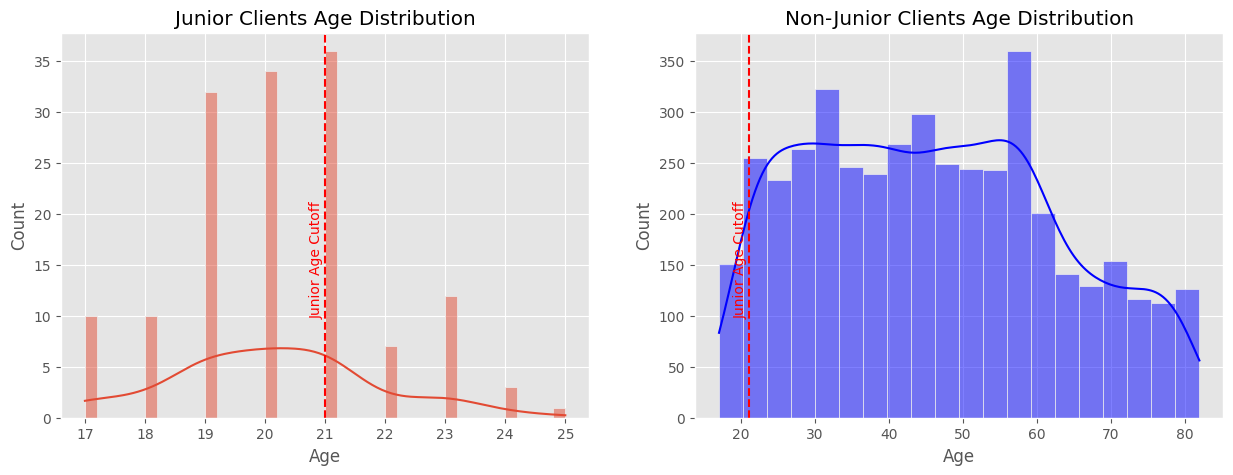

In [158]:
JUNIOR_AGE_CUTOFF = 21

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(junior_clients['client_age'], bins=40, ax=ax[0], kde=True)
ax[0].axvline(JUNIOR_AGE_CUTOFF, color='r', linestyle='--')
ax[0].text(JUNIOR_AGE_CUTOFF - .25, 10, 'Junior Age Cutoff', rotation=90, color='r')
ax[0].set_title('Junior Clients Age Distribution')
ax[0].set_xlabel('Age')

sns.histplot(client_df['client_age'], bins=20, ax=ax[1], color='b', kde=True)
ax[1].axvline(JUNIOR_AGE_CUTOFF, color='r', linestyle='--')
ax[1].text(JUNIOR_AGE_CUTOFF - 2, 100, 'Junior Age Cutoff', rotation=90, color='r')
ax[1].set_title('Non-Junior Clients Age Distribution')
ax[1].set_xlabel('Age')

plt.show()

For the cutoff the age 21 was chosen (meaning non-card-holders that are younger than the threshold or exactly at the threshold) since we can see a rapid decrease in Junior Card Holders after the proposed age. These remaining customers above the cutoff age that still own a Junior card could just remain there due to the reason that the bank may need some time to reissue regular cards; Which is why no clear cutoff age can be found in the distribution.

In [159]:
underage_clients = client_df[(client_df['client_age'] <= JUNIOR_AGE_CUTOFF) & (~client_df['has_card'])]

client_df = client_df[~client_df['client_id'].isin(underage_clients['client_id'])]
transaction = transaction[~transaction['account_id'].isin(underage_clients['account_id'])]

print(f'Number of underage clients: {underage_clients.shape[0]}')
print(f'Number of clients remaining after underage client removal: {client_df.shape[0]}')

Number of underage clients: 222
Number of clients remaining after underage client removal: 4133


## Model Construction

In the model construction step the main goal is to build a "counter quantity". The PKDD'99 dataset unfortunately only labelled preexisiting customers with an issue date. Customers who decided against a card may not be in the dataset or are at least not marked in such a way.

### Processing Transactional Data

The first task is to look if every account in the transactions dataframe has a "first transaction". This would make the calculation of the monthly balance much easier since everything can be summed up without having to worry that there were months without records in the transaction dataframe.

In [160]:
# Find the minimum (first) transaction(s) date for each account
min_dates = transaction.groupby('account_id')['date'].min().reset_index()
min_dates.rename(columns={'date': 'min_date'}, inplace=True)

# Merge the minimum date back to the transactions to identify all transactions on the first day
transactions_with_min_date = pd.merge(transaction, min_dates, on='account_id')

# Filter transactions that are on the first day
first_day_transactions = transactions_with_min_date[transactions_with_min_date['date'] == transactions_with_min_date['min_date']]
first_day_transactions = first_day_transactions.copy()

# Now, for each of these first day transactions, check if any have amount equals balance
first_day_transactions['amount_equals_balance'] = first_day_transactions['amount'] == first_day_transactions['balance']

# Group by account_id and check if any transactions for each account meet the condition
accounts_meeting_condition = first_day_transactions.groupby('account_id')['amount_equals_balance'].any().reset_index()

# Verify if all accounts have at least one transaction on the first day meeting the condition
all_accounts_covered = accounts_meeting_condition['amount_equals_balance'].all()

print("Does every account's first day of transactions include at least one transaction where amount equals balance?", all_accounts_covered)

Does every account's first day of transactions include at least one transaction where amount equals balance? True


Since the goal is to have a roll-up window per month, the transactions need to get modified so that they aggregate their values on a per-month level.

The code first groups the transactions by `account_id` and `month`, and aggregates the data to calculate monthly `volume`, `credit`, `withdrawal`, and the number of transactions (`n_transactions`). After that the minimum and maximum month for each `account_id` gets calculated.

Finally, the cumulative sum of the volume column for each `account_id` is calculated, resulting in a running balance over time.

In [161]:
transaction['month'] = transaction['date'].dt.to_period('M')

transactions_monthly = transaction.groupby(['account_id', 'month']).agg(
    volume=('amount', 'sum'),
    credit=('amount', lambda x: x[x > 0].sum()),
    withdrawal=('amount', lambda x: x[x < 0].sum()),
    n_transactions=('amount', 'size')
).reset_index()

transactions_monthly['month'] = pd.PeriodIndex(transactions_monthly['month'])

date_ranges = transactions_monthly.groupby('account_id')['month'].agg(['min', 'max'])

def reindex_df(group, account_id):
    idx = pd.period_range(start=group['month'].min(), end=group['month'].max(), freq='M')
    group.set_index('month', inplace=True)
    group = group.reindex(idx, fill_value=0)
    group.reset_index(inplace=True)
    group.rename(columns={'index': 'month'}, inplace=True)
    group['account_id'] = account_id
    return group

transactions_monthly = (transactions_monthly.groupby('account_id')
                        .apply(lambda x: reindex_df(x, x.name))
                        .reset_index(level=0, drop=True))

transactions_monthly['balance'] = transactions_monthly.groupby('account_id')['volume'].cumsum()

In [162]:
transactions_monthly.sample(5)

month  account_id   volume   credit  withdrawal  n_transactions  \
5   1998-01        2644  17485.7  17485.7         0.0              13   
22  1995-05        1297  42004.4  42004.4         0.0               7   
15  1998-08         250  11099.8  11099.8         0.0               6   
23  1998-08        1258   5210.7   5210.7         0.0               6   
36  1996-05        3316  33962.0  33962.0         0.0               5   

      balance  
5     46045.3  
22   933208.2  
15   202891.1  
23   127985.3  
36  1210751.5

### Defining Roll-Up Windows of Transactions

Before we can continue to construct the roll-up windows for all customers, we need to propose a hypothetical `card_issued` date for the clients that have **no card** (negative samples).

To not introduce a new bias towards card-holders or non-card-holders the idea here is to sample issue dates from the card holders. An important point is to eliminate or surpress seasonality as good as possible (hence a 13 month roll-up window will be constructed). Such seasonality could also emerge if we just sample random dates - To not encounter that issue and get a counter set to our existing card holders, the distribution of days between account creation and the issue date is used. This way we can ensure that we don't sample dates that lie outside of a non-card customer's account activity.

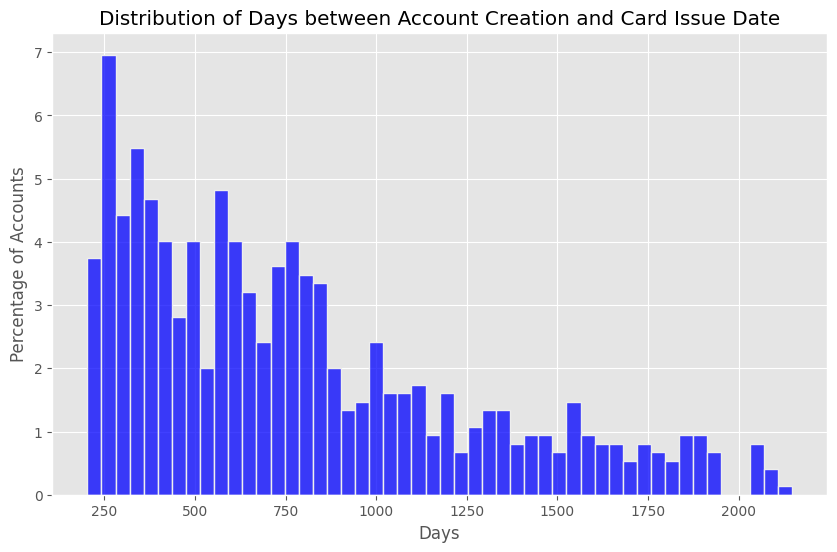

In [163]:
clients_with_cards = client_df[~client_df['card_issued'].isnull()]
time_between_creation_and_issue = (clients_with_cards['card_issued'] - clients_with_cards['account_date']).dt.days

plt.figure(figsize=(10, 6))
sns.histplot(time_between_creation_and_issue, bins=50, stat='percent', kde=False, color='blue', linewidth=1)

plt.title('Distribution of Days between Account Creation and Card Issue Date')
plt.xlabel('Days')
plt.ylabel('Percentage of Accounts')
plt.grid(True)

plt.show()

When looking at the distribution of how many days it usually takes an account to get a card is that usually cards get issued the earliest 200 days after account creation. The issuances decrease steadily but in rare cases it can even take a customer over 5 years (>2000 days) to decide to get a credit card.

Based on this distribution we now will sample the deltas (time between account creation and issuance) for our non-card holders.

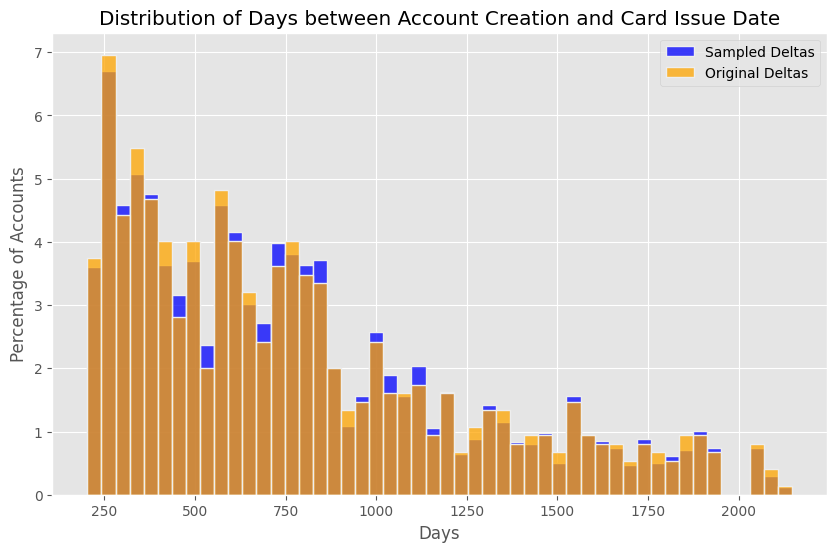

In [164]:
np.random.seed(1337)

sampled_deltas = np.random.choice(time_between_creation_and_issue, size=len(client_df[client_df['card_issued'].isnull()]))

plt.figure(figsize=(10, 6))
sns.histplot(sampled_deltas, bins=50, stat='percent', kde=False, color='blue', linewidth=1, label='Sampled Deltas')
sns.histplot(time_between_creation_and_issue, bins=50, stat='percent', kde=False, color='orange', linewidth=1, label='Original Deltas')

plt.title('Distribution of Days between Account Creation and Card Issue Date')
plt.xlabel('Days')
plt.ylabel('Percentage of Accounts')
plt.legend()
plt.grid(True)

plt.show()

Through the random sampling we now can use every negative sample from the dataset. Additionally, through random sampling we added a small amount of noise which is expected to have a generalizing effect on the data.

To check if we now have an issue date for all customers the following check is executed:

In [165]:
if len(client_df[client_df['card_issued'].isnull()]) > 0:
    client_df.loc[client_df['card_issued'].isnull(), 'card_issued'] = client_df.loc[client_df['card_issued'].isnull(), 'account_date'] + pd.to_timedelta(sampled_deltas, unit='D')
    
print(f'Number of NaT/NaN values in card_issued: {client_df["card_issued"].isnull().sum()}')

Number of NaT/NaN values in card_issued: 0


The check shows that we now successfully sampled an issue date for all customers.

In [166]:
card_issued = card.groupby('disp_id')['card_issued'].min().reset_index()
card_issued.head(5)

disp_id card_issued
0        9  1998-10-16
1       19  1998-03-13
2       41  1995-09-03
3       42  1998-11-26
4       51  1995-04-24

We now can merge together the issued dates to the monthly transaction aggregation.

In [167]:
transactions_monthly = transactions_monthly.merge(client_df[['account_id', 'card_issued']], left_on='account_id', right_on='account_id', how='left')

transactions_monthly.head()

month  account_id   volume   credit  withdrawal  n_transactions  balance  \
0  1995-03           1   1000.0   1000.0         0.0               1   1000.0   
1  1995-04           1  16298.2  16298.2         0.0               3  17298.2   
2  1995-05           1   5858.0   5858.0         0.0               3  23156.2   
3  1995-06           1   3979.6   3979.6         0.0               3  27135.8   
4  1995-07           1   9087.9   9087.9         0.0               3  36223.7   

  card_issued  
0  1998-09-18  
1  1998-09-18  
2  1998-09-18  
3  1998-09-18  
4  1998-09-18

Now, let's see if the join worked correctly and we don't have any transactions without a `card_issued` date anymore.

In [168]:
assert transactions_monthly['card_issued'].isnull().sum() == 0

### Validating Negative Examples
The goal for our model will be to be able to learn from a base set of customers (with and without cards) that lived through the same economic circumstances. To validate that all customers in our current set are represented in a well distributed way, this next plot looks at the distribution of volume throughout the datasets timeframe.

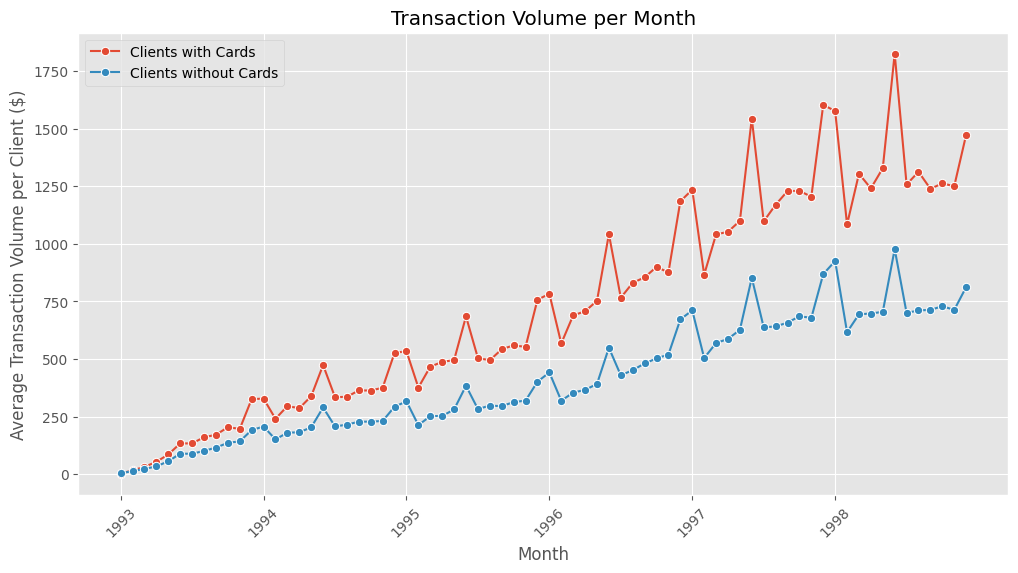

In [169]:
transactions_monthly['has_card'] = transactions_monthly['account_id'].isin(client_df[client_df['has_card']]['account_id'])

transactions_monthly.reset_index(inplace=True)
transactions_monthly['id'] = range(len(transactions_monthly))
transactions_monthly.set_index('id', inplace=True)

transactions_with_cards = transactions_monthly[transactions_monthly['has_card'] == True]
transactions_without_cards = transactions_monthly[transactions_monthly['has_card'] == False]

grouped_with_cards = transactions_with_cards.groupby('month')['volume'].sum().reset_index()
grouped_without_cards = transactions_without_cards.groupby('month')['volume'].sum().reset_index()

grouped_with_cards['month'] = grouped_with_cards['month'].astype(str)
grouped_without_cards['month'] = grouped_without_cards['month'].astype(str)

grouped_with_cards['avg_volume_per_client'] = grouped_with_cards['volume'] / transactions_with_cards.shape[0]
grouped_without_cards['avg_volume_per_client'] = grouped_without_cards['volume'] / transactions_without_cards.shape[0]

plt.figure(figsize=(12, 6))

sns.lineplot(x='month', y='avg_volume_per_client', data=grouped_with_cards, marker='o', label='Clients with Cards')
sns.lineplot(x='month', y='avg_volume_per_client', data=grouped_without_cards, marker='o', label='Clients without Cards')

plt.title('Transaction Volume per Month')
plt.xlabel('Month')
plt.ylabel('Average Transaction Volume per Client ($)')
plt.legend()
plt.grid(True)

plt.xticks(ticks=grouped_with_cards['month'][grouped_with_cards['month'].str.endswith('-01')], rotation=45)
plt.gca().set_xticklabels([label[:4] for label in grouped_with_cards['month'][grouped_with_cards['month'].str.endswith('-01')]])

plt.show()


We can see that we generally have less transaction volume for clients without cards, though the trends stay the same for both customer types: Around Christmas and New Year's Eve the transaction volume rises rapidly. The same observation can be seen in the middle of each year, perhaps where customers go on summer vacation.

In order to construct the Roll-Up Window for every customer, the difference of each month to the issue date's month needs to get calculated. After calculating the difference at each month the size of the Roll-Up window can be determined. In this case a window of 13 months was chosen, so a year plus a lag month which aims to capture the client's decision time or the banks time until the card has been sent out to the customer.

In [170]:
transactions_monthly['card_issued'] = pd.to_datetime(transactions_monthly['card_issued'])
transactions_monthly['card_issued_period'] = transactions_monthly['card_issued'].dt.to_period('M')

transactions_monthly['month_diff'] = transactions_monthly.apply(lambda row: (row['card_issued_period'] - row['month']).n if pd.notnull(row['card_issued_period']) and pd.notnull(row['month']) else None, axis=1)

filtered_transactions = transactions_monthly[transactions_monthly['month_diff'].between(1, 13)]

transactions_monthly.sample(5)

index    month  account_id   volume   credit  withdrawal  \
id                                                                  
44634    44634  1998-05        1252  47796.5  47796.5         0.0   
44011    44011  1997-07        1235  10518.0  10518.0         0.0   
95818    95818  1997-12        2651  98919.1  98919.1         0.0   
73459    73459  1996-08        2035  52500.5  52500.5         0.0   
162431  162431  1995-08        8998   1900.0   1900.0         0.0   

        n_transactions    balance card_issued  has_card card_issued_period  \
id                                                                           
44634                5  1777803.9  1999-05-20     False            1999-05   
44011                6   373341.3  1995-12-18     False            1995-12   
95818                6  4442381.9  1995-07-09      True            1995-07   
73459                3   155070.1  2000-06-14     False            2000-06   
162431               1    21400.0  1997-11-23     False            1997-11   

        month_diff  
id                  
44634           12  
44011          -19  
95818          -29  
73459           46  
162431          27

The sample and assertions shows, as expected, the dataframe now has a `month_diff` column describing how many months until the issue month.

#### Pivoting the transactions

An issue at this point can be that an account may have months without any transactions, so there needs to be a more thorough process to interpolate the data:
- **Volume, Withdrawal, Credit and Number of Transactions**: If there are missing months in these variables we can just set `0` as their value as there has not been any activity if there were no recorded months.
- **Balance**: The balance will get recursively set to the last preceding recorded month. So if there are consecutive "missing" months in transactions the balance will always be set to the last recorded month.

In [172]:
account_summary = pd.DataFrame(filtered_transactions['account_id'].unique(), columns=['account_id'])

variables_to_pivot = ['volume', 'withdrawal', 'credit', 'n_transactions', 'balance']

for variable in variables_to_pivot:
    grouped = filtered_transactions.groupby(['account_id', 'month_diff'])[variable].sum().reset_index()
    pivot = grouped.pivot(index='account_id', columns='month_diff', values=variable).reset_index()
    pivot.columns = ['account_id'] + [f'{variable}_month_diff_{int(col)}' if col != 'account_id' else 'account_id' for col in pivot.columns[1:]]
    account_summary = pd.merge(account_summary, pivot, on='account_id', how='left')

for variable in ['volume', 'withdrawal', 'credit', 'n_transactions']:
    account_summary.update(account_summary.filter(regex=f'^{variable}_').fillna(0))

def find_last_balance(account_id, starting_month_diff):
    higher_month_diff = transactions_monthly[
        (transactions_monthly['account_id'] == account_id) & 
        (transactions_monthly['month_diff'] >= starting_month_diff)
    ].sort_values('month_diff')
    
    last_balance_row = higher_month_diff[higher_month_diff['balance'].notna()].head(1)
    
    if not last_balance_row.empty:
        return last_balance_row.iloc[0]['balance']
    else:
        return 0

balance_columns = [col for col in account_summary.columns if 'balance_month_diff_' in col]
for idx, row in account_summary.iterrows():
    for col in balance_columns:
        if pd.isna(row[col]):
            month_diff = int(col.split('_')[-1])
            last_balance = find_last_balance(row['account_id'], month_diff + 1)
            account_summary.at[idx, col] = last_balance
            
account_summary.sample(5)

As we can see, the columns get pivoted correctly and now every account has its 13-month roll-up window so we can merge together the window with the existing client dataframe (main dataframe).

In [38]:
client_df = client_df.merge(account_summary, on='account_id', how='inner')

### Bringing the data together

Since we now are done with the main model construction, the following visualization aims to show and recap the process we went through with the data at hand.

In [39]:
n_lt_13_month_hist = transactions_monthly['account_id'].nunique()-filtered_transactions['account_id'].nunique()

preprocessing_summary = [
        n_merged_base_client,
        -len(junior_clients),
        -n_lt_13_month_hist,
        -len(underage_clients),
        len(client_df)
]

fig = go.Figure(go.Waterfall(
        name = "20", orientation = "v",
        measure = ["absolute", "relative", "relative", "relative", "total"],
        x = ["Base Client List", 
             "Junior Clients", 
             "Clients with less than 13 Months of Transaction History", 
             "Non-Card-Holders that are underage", 
             "Remaining Clients"],
        textposition = "outside",
        y = preprocessing_summary,
        text = [str(x) for x in preprocessing_summary],
        connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "Profit and loss statement 2018",
        showlegend = True
)

fig.show()

The baseline dataset consists of 4500 clients. Of these 4500 clients 145 are Junior Clients and those need to get removed since the task at hand does not focus on this customer group. After the Junior card removal clients with less than 13 months of history were discarded since those do not have enough time as a customer to build a roll-up window and therefore would not be suitable to make any predictions with. An implicit dependency with the Junior cards is the age - Customers without cards that may fall into the category of Junior customers also got discarded since our model would not be suitable to classify if such "underage" customers should get a card or not. The remaining dataset or "golden record" therefore consists of 3715 customers.

## Exploratory Data Analysis

### Exploring Missing Values

In [40]:
missing_values = client_df.isnull().sum()

missing_values = pd.DataFrame({
    'Number of Missing Values': missing_values[missing_values > 0],
    'Percentage of Missing Values': [
        f"{x:.2f}%" for x in (missing_values[missing_values > 0] / client_df.shape[0] * 100).round(2)
    ]
}, columns=['Number of Missing Values', 'Percentage of Missing Values'])

fig = go.Figure()

fig.add_trace(go.Bar(
    x=missing_values.index,
    y=missing_values['Number of Missing Values'],
    text=missing_values['Percentage of Missing Values'],
    textposition='auto'
))

fig.update_layout(
    title='Missing Values in the Dataset',
    xaxis_title='Columns',
    yaxis_title='Number of Missing Values'
)

fig.show()

### Cardholders vs Non-Cardholders

In [41]:
card_owners = client_df[client_df['has_card']]
non_card_owners = client_df[~client_df['has_card']]

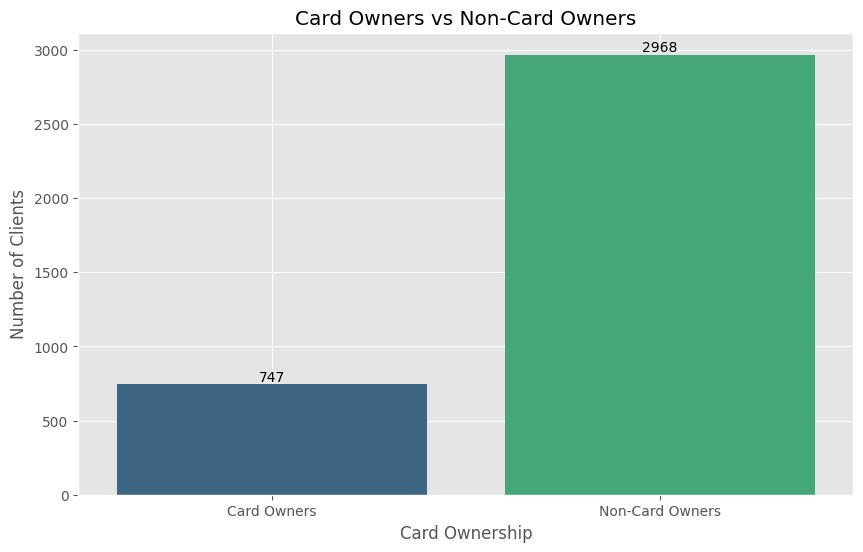

In [42]:
data = {
    'Card Ownership': ['Card Owners', 'Non-Card Owners'],
    'Number of Clients': [card_owners.shape[0], non_card_owners.shape[0]]
}

plt.figure(figsize=(10, 6))
sns.barplot(x='Card Ownership', y='Number of Clients', data=data, palette='viridis', hue='Card Ownership')

for index, value in enumerate(data['Number of Clients']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Card Owners vs Non-Card Owners')
plt.xlabel('Card Ownership')
plt.ylabel('Number of Clients')
plt.grid(True)

plt.show()


###  Card Types

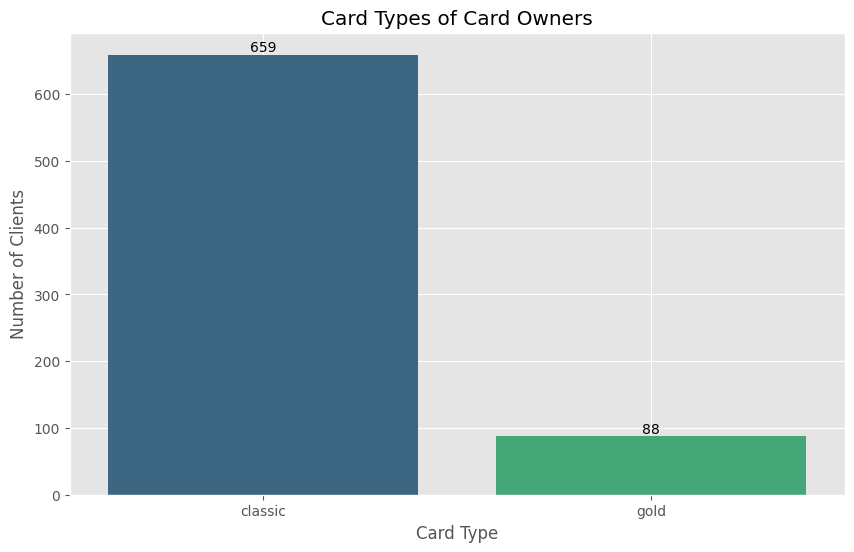

In [43]:
card_types = card_owners['card_type'].value_counts()
card_types = card_types.reset_index()
card_types.columns = ['Card Type', 'Number of Clients']

plt.figure(figsize=(10, 6))
sns.barplot(x='Card Type', y='Number of Clients', data=card_types, palette='viridis', hue='Card Type')

for index, value in enumerate(card_types['Number of Clients']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.title('Card Types of Card Owners')
plt.xlabel('Card Type')
plt.ylabel('Number of Clients')
plt.grid(True)

plt.show()

### Distribution of Issuance Dates

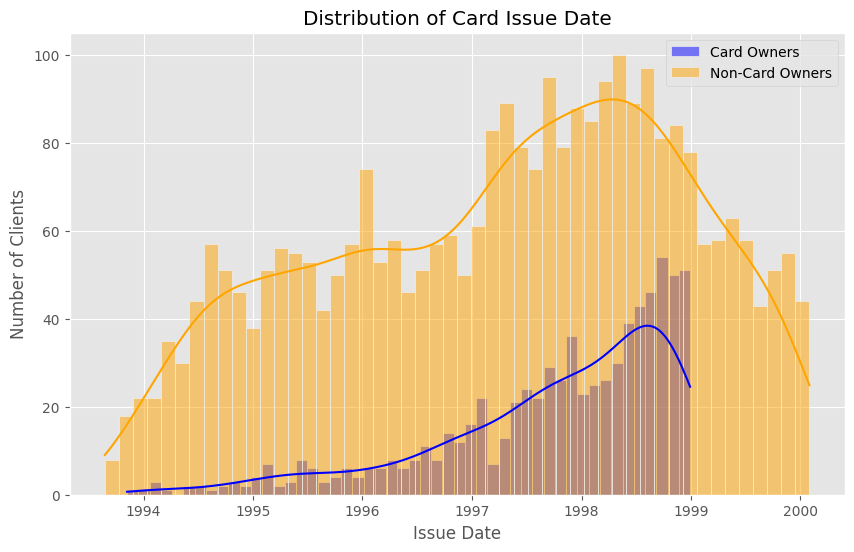

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(card_owners['card_issued'], bins=50, kde=True, color='blue', label='Card Owners')
sns.histplot(non_card_owners['card_issued'], bins=50, kde=True, color='orange', label='Non-Card Owners')

plt.title('Distribution of Card Issue Date')
plt.xlabel('Issue Date')
plt.ylabel('Number of Clients')
plt.legend()
plt.grid(True)

plt.show()

### Balance and Volume over time

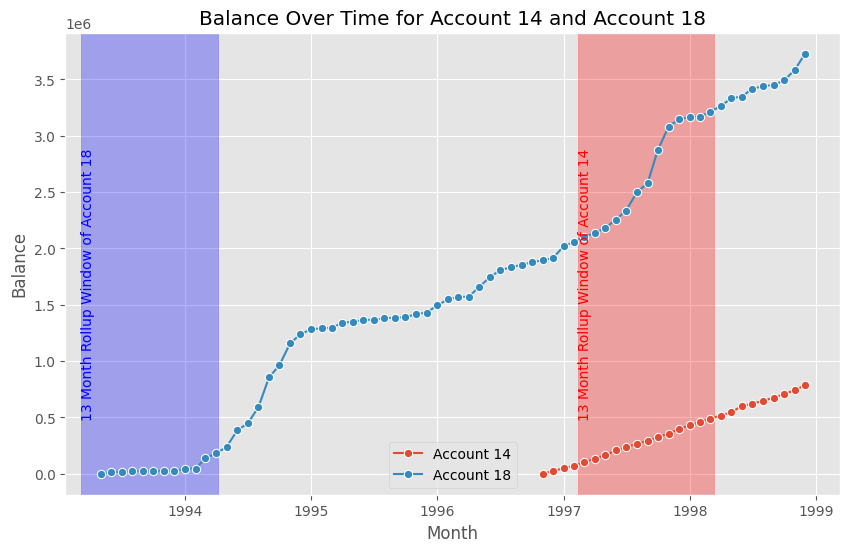

In [45]:
account_14 = transactions_monthly[transactions_monthly['account_id'] == 14].copy()
account_14['month'] = account_14['month'].dt.to_timestamp()

account_18 = transactions_monthly[transactions_monthly['account_id'] == 18].copy()
account_18['month'] = account_18['month'].dt.to_timestamp()

plt.figure(figsize=(10, 6))
sns.lineplot(data=account_14, x='month', y='balance', marker='o', label='Account 14')
sns.lineplot(data=account_18, x='month', y='balance', marker='o', label='Account 18')

plt.axvspan(account_14['card_issued'].min() - pd.DateOffset(months=13), account_14['card_issued'].min(), color='r', alpha=0.3)
plt.axvspan(account_18['card_issued'].min() - pd.DateOffset(months=13), account_18['card_issued'].min(), color='b', alpha=0.3)

plt.text(account_14['card_issued'].min() - pd.DateOffset(months=13), 500000, '13 Month Rollup Window of Account 14', rotation=90, color='r')
plt.text(account_18['card_issued'].min() - pd.DateOffset(months=13), 500000, '13 Month Rollup Window of Account 18', rotation=90, color='b')

plt.title('Balance Over Time for Account 14 and Account 18')
plt.xlabel('Month')
plt.ylabel('Balance')
plt.legend()
plt.grid(True)

plt.show()

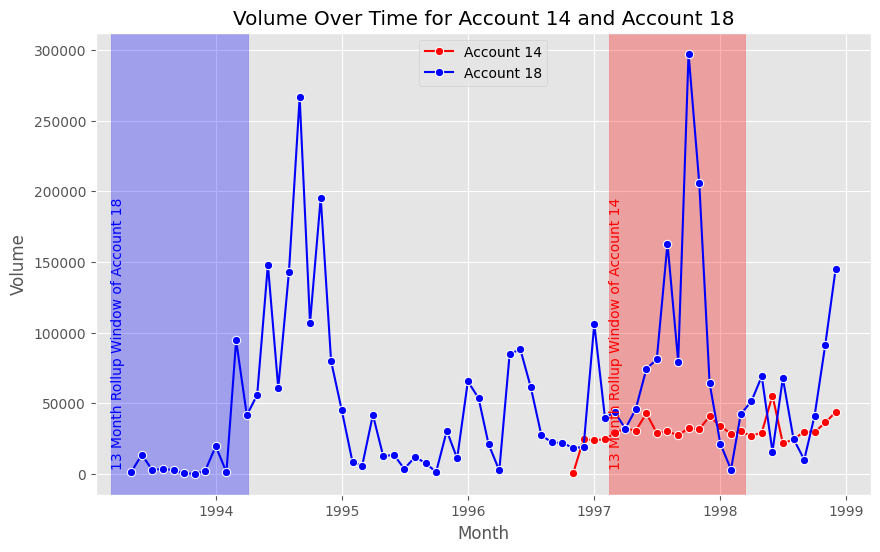

In [46]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='volume', data=account_14, marker='o', label='Account 14', color='r')
sns.lineplot(x='month', y='volume', data=account_18, marker='o', label='Account 18', color='b')

plt.axvspan(account_14['card_issued'].min() - pd.DateOffset(months=13), account_14['card_issued'].min(), color='r', alpha=0.3)
plt.axvspan(account_18['card_issued'].min() - pd.DateOffset(months=13), account_18['card_issued'].min(), color='b', alpha=0.3)

plt.text(account_14['card_issued'].min() - pd.DateOffset(months=13), 5000, '13 Month Rollup Window of Account 14', rotation=90, color='r')
plt.text(account_18['card_issued'].min() - pd.DateOffset(months=13), 5000, '13 Month Rollup Window of Account 18', rotation=90, color='b')

plt.title('Volume Over Time for Account 14 and Account 18')
plt.xlabel('Month')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)

### Volume before card purchase

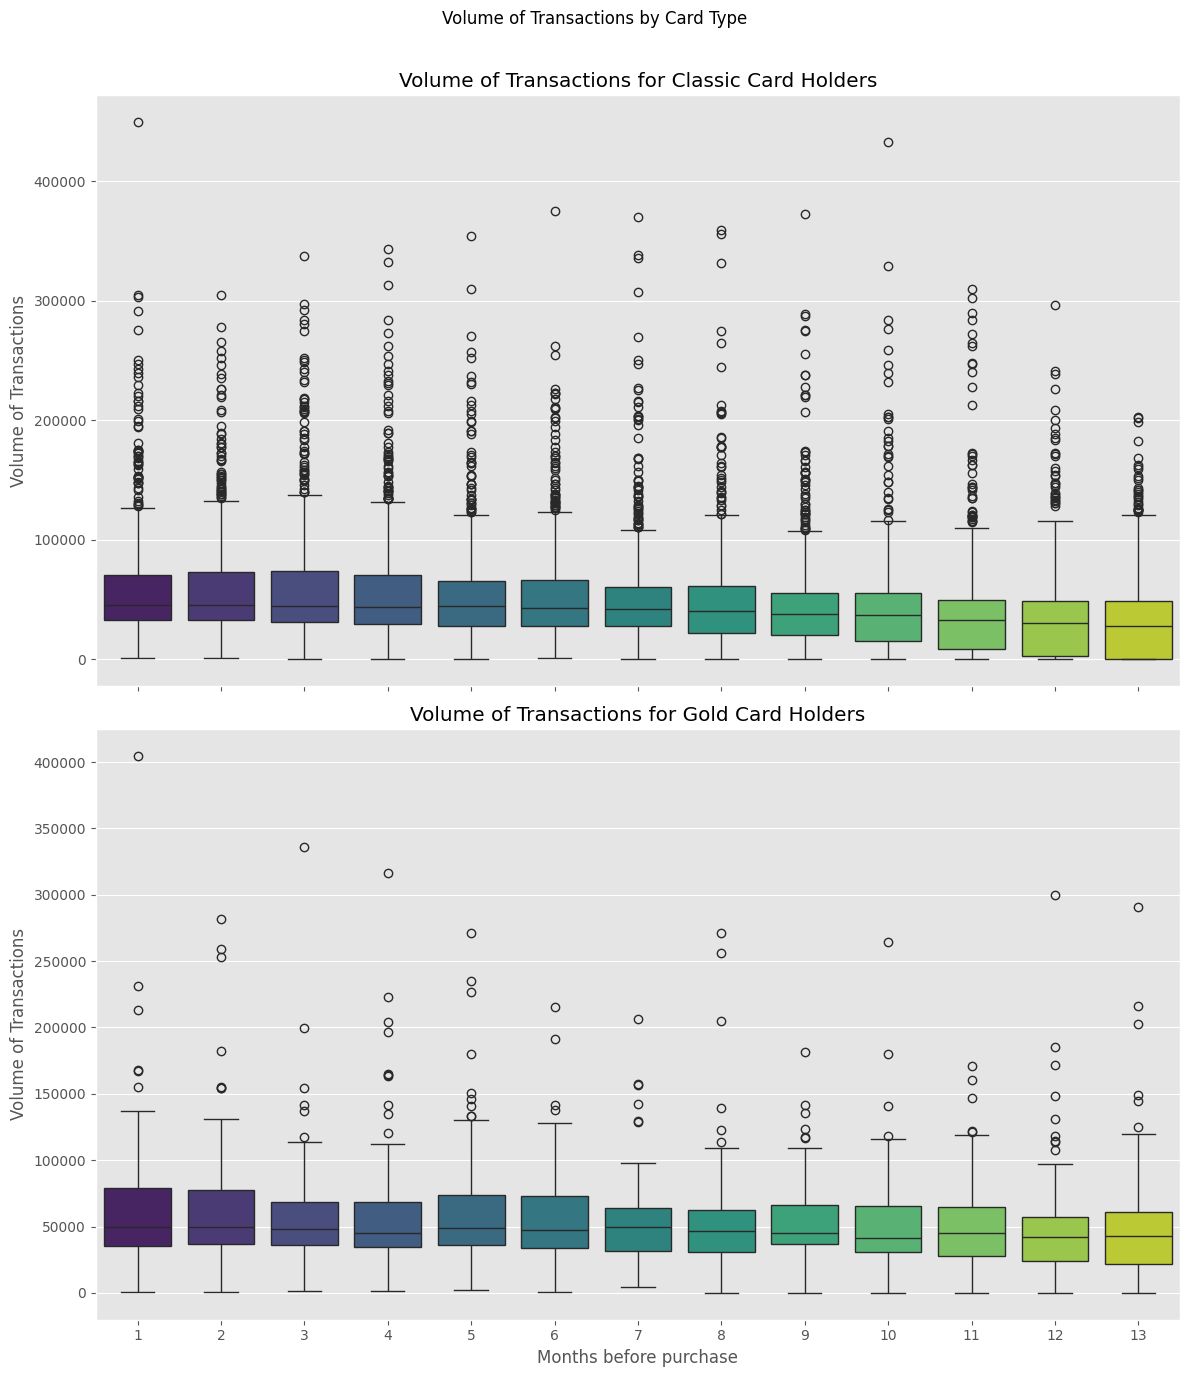

In [47]:
classic_card_type_df = card_owners[card_owners['card_type'] == 'classic']
gold_card_type_df = card_owners[card_owners['card_type'] == 'gold']

volume_month_diff_columns = [col for col in account_summary.columns if 'volume_month_diff_' in col]

classic_data = []
gold_data = []

for col in volume_month_diff_columns:
    month_num = col.split('_')[-1]
    for value in classic_card_type_df[col]:
        classic_data.append({'Month': month_num, 'Volume': value, 'Card Type': 'Classic'})

for col in volume_month_diff_columns:
    month_num = col.split('_')[-1]
    for value in gold_card_type_df[col]:
        gold_data.append({'Month': month_num, 'Volume': value, 'Card Type': 'Gold'})

combined_data = classic_data + gold_data

combined_df = pd.DataFrame(combined_data)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 14), sharex=True)

sns.boxplot(ax=axes[0], x='Month', y='Volume', data=combined_df[combined_df['Card Type'] == 'Classic'], palette='viridis', hue='Month')
axes[0].set_title('Volume of Transactions for Classic Card Holders')
axes[0].set_xlabel('Months before purchase')
axes[0].set_ylabel('Volume of Transactions')

sns.boxplot(ax=axes[1], x='Month', y='Volume', data=combined_df[combined_df['Card Type'] == 'Gold'], palette='viridis', hue='Month')
axes[1].set_title('Volume of Transactions for Gold Card Holders')
axes[1].set_xlabel('Months before purchase')
axes[1].set_ylabel('Volume of Transactions')

fig.suptitle('Volume of Transactions by Card Type')
plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

### Age distribution

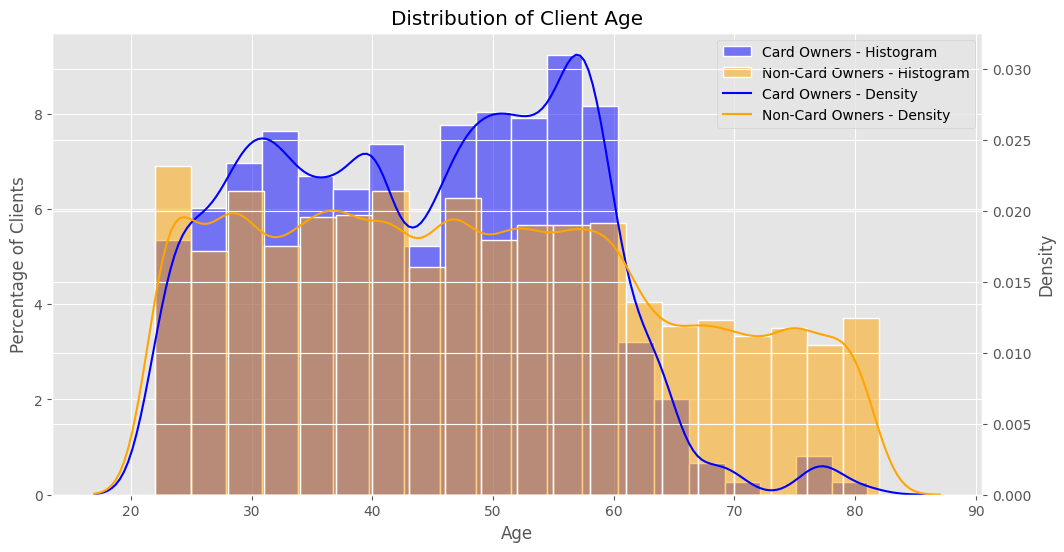

In [48]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot histograms with percentage normalization on the left y-axis
sns.histplot(card_owners['client_age'], bins=20, stat='percent', kde=False, color='blue', edgecolor='white', linewidth=1, label='Card Owners - Histogram', alpha=0.5, ax=ax1)
sns.histplot(non_card_owners['client_age'], bins=20, stat='percent', kde=False, color='orange', edgecolor='white', linewidth=1, label='Non-Card Owners - Histogram', alpha=0.5, ax=ax1)

# Set up the second y-axis
ax2 = ax1.twinx()

# Plot density plots on the right y-axis
sns.kdeplot(card_owners['client_age'], bw_adjust=0.5, color='blue', label='Card Owners - Density', ax=ax2)
sns.kdeplot(non_card_owners['client_age'], bw_adjust=0.5, color='orange', label='Non-Card Owners - Density', ax=ax2)

# Set the titles and labels
ax1.set_title('Distribution of Client Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Percentage of Clients')
ax2.set_ylabel('Density')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

# Show the plot
plt.grid(True)
plt.show()

## Feature Engineering

### Demographic-Based Features
1. Defining Age Groups
The `pd.cut()` function bins continuous data into discrete intervals based on specified edges, with the default behavior including the left edge and excluding the right edge of each interval. The ages get binned by assigning each age value to an interval defined by specified edges, such as [0, 20), [20, 30), and so on, where each interval includes the left edge and excludes the right edge by default.

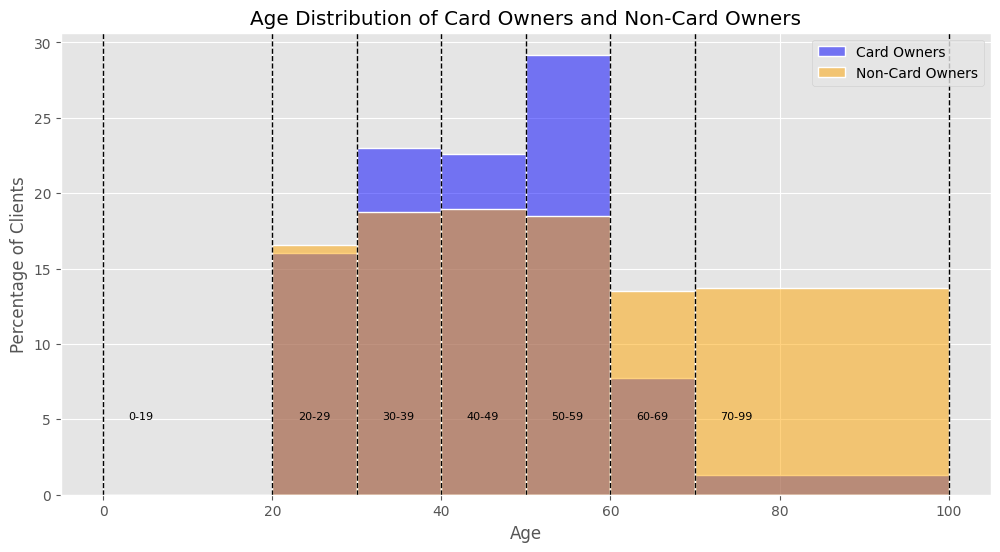

In [49]:
age_brackets = [0, 20, 30, 40, 50, 60, 70, 100]

plt.figure(figsize=(12, 6))
sns.histplot(card_owners['client_age'], bins=age_brackets, stat='percent', kde=False, color='blue', edgecolor='white', linewidth=1, label='Card Owners', alpha=0.5)
sns.histplot(non_card_owners['client_age'], bins=age_brackets, stat='percent', kde=False, color='orange', edgecolor='white', linewidth=1, label='Non-Card Owners', alpha=0.5)

for age_bracket in age_brackets:
    plt.axvline(age_bracket, color='black', linestyle='--', linewidth=1)
    
plt.title('Age Distribution of Card Owners and Non-Card Owners')
plt.xlabel('Age')
plt.ylabel('Percentage of Clients')

for i in range(len(age_brackets) - 1):
    plt.text(age_brackets[i] + 3, 5, f'{age_brackets[i]}-{age_brackets[i+1]-1}', fontsize=8, color='black')
    
plt.legend()
plt.grid(True)

plt.show()

In [50]:
client_df['age_bracket'] = pd.cut(client_df['client_age'], bins=age_brackets, right=False)

age_bracket_counts = client_df['age_bracket'].value_counts().reset_index()
age_bracket_counts.columns = ['Age Bracket', 'Number of Clients']

age_bracket_counts

Age Bracket  Number of Clients
0    [50, 60)                767
1    [40, 50)                732
2    [30, 40)                729
3    [20, 30)                611
4    [60, 70)                460
5   [70, 100)                416
6     [0, 20)                  0

2. Age at Loan

In [51]:
client_df['client_age_at_loan'] = (pd.to_datetime(client_df['loan_date']) - pd.to_datetime(client_df['client_birth_date'])).dt.days // 365

client_df.head(5)

disp_id  client_id  account_id  account_district_id account_frequency  \
0        1          1           1                   18   MONTHLY CHARGES   
1        2          2           2                    1   MONTHLY CHARGES   
2        6          6           4                   12   MONTHLY CHARGES   
3        7          7           5                   15   MONTHLY CHARGES   
4        8          8           6                   51   MONTHLY CHARGES   

  account_date  client_district_id client_gender client_birth_date  \
0   1995-03-24                  18        FEMALE        1970-12-13   
1   1993-02-26                   1          MALE        1945-02-04   
2   1996-02-21                  12          MALE        1919-09-22   
3   1997-05-30                  15          MALE        1929-01-25   
4   1994-09-27                  51        FEMALE        1938-02-21   

   client_age  ordertype_HOUSEHOLD  ordertype_INSURANCE PAYMENT  \
0          29                  1.0                          0.0   
1          54                  1.0                          0.0   
2          80                  2.0                          0.0   
3          70                  1.0                          0.0   
4          61                  1.0                          0.0   

   ordertype_LEASING  ordertype_LOAN PAYMENT  ordertype_MISSING  loan_id  \
0                0.0                     0.0                0.0      NaN   
1                0.0                     1.0                0.0   4959.0   
2                0.0                     0.0                0.0      NaN   
3                0.0                     0.0                0.0      NaN   
4                0.0                     0.0                0.0      NaN   

   loan_date  loan_amount  loan_duration  loan_payments  \
0        NaT          NaN            NaN            NaN   
1 1994-01-05      80952.0           24.0         3373.0   
2        NaT          NaN            NaN            NaN   
3        NaT          NaN            NaN            NaN   
4        NaT          NaN            NaN            NaN   

                      loan_status  card_id card_type card_issued  \
0                             NaN      NaN       NaN  1998-09-18   
1  contract finished, no problems      NaN       NaN  1993-11-29   
2                             NaN      NaN       NaN  1997-10-26   
3                             NaN      NaN       NaN  1998-04-27   
4                             NaN      NaN       NaN  1998-11-27   

   district_id_x client_district_district_name client_district_region  \
0             18                         Pisek          south Bohemia   
1              1                   Hl.m. Praha                 Prague   
2             12                       Pribram        central Bohemia   
3             15                 Cesky Krumlov          south Bohemia   
4             51                       Trutnov           east Bohemia   

   client_district_population  \
0                       70699   
1                     1204953   
2                      107870   
3                       58796   
4                      121947   

   client_district_n_municipalities_with_inhabitants_lt_499  \
0                                                 60          
1                                                  0          
2                                                 84          
3                                                 22          
4                                                 37          

   client_district_n_municipalities_with_inhabitants_500_to_1999  \
0                                                 13               
1                                                  0               
2                                                 29               
3                                                 16               
4                                                 28               

   client_district_n_municipalities_with_inhabitants_2000_to_9999  \
0     

### Temporal Features
Account age

In [52]:
client_df['account_age'] = (pd.to_datetime('2000-01-01') - pd.to_datetime(client_df['account_date'])).dt.days // 365

client_df.head(5)

disp_id  client_id  account_id  account_district_id account_frequency  \
0        1          1           1                   18   MONTHLY CHARGES   
1        2          2           2                    1   MONTHLY CHARGES   
2        6          6           4                   12   MONTHLY CHARGES   
3        7          7           5                   15   MONTHLY CHARGES   
4        8          8           6                   51   MONTHLY CHARGES   

  account_date  client_district_id client_gender client_birth_date  \
0   1995-03-24                  18        FEMALE        1970-12-13   
1   1993-02-26                   1          MALE        1945-02-04   
2   1996-02-21                  12          MALE        1919-09-22   
3   1997-05-30                  15          MALE        1929-01-25   
4   1994-09-27                  51        FEMALE        1938-02-21   

   client_age  ordertype_HOUSEHOLD  ordertype_INSURANCE PAYMENT  \
0          29                  1.0                          0.0   
1          54                  1.0                          0.0   
2          80                  2.0                          0.0   
3          70                  1.0                          0.0   
4          61                  1.0                          0.0   

   ordertype_LEASING  ordertype_LOAN PAYMENT  ordertype_MISSING  loan_id  \
0                0.0                     0.0                0.0      NaN   
1                0.0                     1.0                0.0   4959.0   
2                0.0                     0.0                0.0      NaN   
3                0.0                     0.0                0.0      NaN   
4                0.0                     0.0                0.0      NaN   

   loan_date  loan_amount  loan_duration  loan_payments  \
0        NaT          NaN            NaN            NaN   
1 1994-01-05      80952.0           24.0         3373.0   
2        NaT          NaN            NaN            NaN   
3        NaT          NaN            NaN            NaN   
4        NaT          NaN            NaN            NaN   

                      loan_status  card_id card_type card_issued  \
0                             NaN      NaN       NaN  1998-09-18   
1  contract finished, no problems      NaN       NaN  1993-11-29   
2                             NaN      NaN       NaN  1997-10-26   
3                             NaN      NaN       NaN  1998-04-27   
4                             NaN      NaN       NaN  1998-11-27   

   district_id_x client_district_district_name client_district_region  \
0             18                         Pisek          south Bohemia   
1              1                   Hl.m. Praha                 Prague   
2             12                       Pribram        central Bohemia   
3             15                 Cesky Krumlov          south Bohemia   
4             51                       Trutnov           east Bohemia   

   client_district_population  \
0                       70699   
1                     1204953   
2                      107870   
3                       58796   
4                      121947   

   client_district_n_municipalities_with_inhabitants_lt_499  \
0                                                 60          
1                                                  0          
2                                                 84          
3                                                 22          
4                                                 37          

   client_district_n_municipalities_with_inhabitants_500_to_1999  \
0                                                 13               
1                                                  0               
2                                                 29               
3                                                 16               
4                                                 28               

   client_district_n_municipalities_with_inhabitants_2000_to_9999  \
0     

### Financial Features
Amount of Loan Paid already

In [53]:
client_df['total_loan_amount_paid'] = client_df['loan_payments'] * client_df['loan_duration']

Average Monthly Payment Ratio: Calculate the ratio of monthly loan payment to average salary in the account's district.

In [54]:
client_df['monthly_payment_ratio'] = client_df['loan_payments'] / client_df['account_district_average_salary']

### District Features
Client-Account Region Match: Create a variable indicating if the client and account regions match.

In [55]:
client_df['region_match'] = client_df['client_district_region'] == client_df['account_district_region']

District Population Density: Calculate the population density for client and account districts (if area data is available).

In [56]:
client_df['client_district_population_density'] = client_df['client_district_population'] / client_df['client_district_n_cities']
client_df['account_district_population_density'] = client_df['account_district_population'] / client_df['account_district_n_cities']

### Event-Based Statistics

In [57]:
transactions_monthly['card_issued'] = pd.to_datetime(transactions_monthly['card_issued'])

transactions_monthly['month'] = transactions_monthly['month'].apply(lambda x: x.to_timestamp() if isinstance(x, pd.Period) else x)

transactions_filtered = transactions_monthly[transactions_monthly['month'] < transactions_monthly['card_issued']]

stat_columns = ['volume', 'credit', 'withdrawal', 'n_transactions', 'balance']

stats = transactions_filtered.groupby('account_id')[stat_columns].agg(['mean', 'std', 'min', 'max', 'sum', 'median']).reset_index()

stats.columns = ['account_id'] + [f"pre_card_{col[0]}_{col[1]}" for col in stats.columns[1:]]

client_df = client_df.merge(stats, on='account_id', how='left')

client_df.head(5)

disp_id  client_id  account_id  account_district_id account_frequency  \
0        1          1           1                   18   MONTHLY CHARGES   
1        2          2           2                    1   MONTHLY CHARGES   
2        6          6           4                   12   MONTHLY CHARGES   
3        7          7           5                   15   MONTHLY CHARGES   
4        8          8           6                   51   MONTHLY CHARGES   

  account_date  client_district_id client_gender client_birth_date  \
0   1995-03-24                  18        FEMALE        1970-12-13   
1   1993-02-26                   1          MALE        1945-02-04   
2   1996-02-21                  12          MALE        1919-09-22   
3   1997-05-30                  15          MALE        1929-01-25   
4   1994-09-27                  51        FEMALE        1938-02-21   

   client_age  ordertype_HOUSEHOLD  ordertype_INSURANCE PAYMENT  \
0          29                  1.0                          0.0   
1          54                  1.0                          0.0   
2          80                  2.0                          0.0   
3          70                  1.0                          0.0   
4          61                  1.0                          0.0   

   ordertype_LEASING  ordertype_LOAN PAYMENT  ordertype_MISSING  loan_id  \
0                0.0                     0.0                0.0      NaN   
1                0.0                     1.0                0.0   4959.0   
2                0.0                     0.0                0.0      NaN   
3                0.0                     0.0                0.0      NaN   
4                0.0                     0.0                0.0      NaN   

   loan_date  loan_amount  loan_duration  loan_payments  \
0        NaT          NaN            NaN            NaN   
1 1994-01-05      80952.0           24.0         3373.0   
2        NaT          NaN            NaN            NaN   
3        NaT          NaN            NaN            NaN   
4        NaT          NaN            NaN            NaN   

                      loan_status  card_id card_type card_issued  \
0                             NaN      NaN       NaN  1998-09-18   
1  contract finished, no problems      NaN       NaN  1993-11-29   
2                             NaN      NaN       NaN  1997-10-26   
3                             NaN      NaN       NaN  1998-04-27   
4                             NaN      NaN       NaN  1998-11-27   

   district_id_x client_district_district_name client_district_region  \
0             18                         Pisek          south Bohemia   
1              1                   Hl.m. Praha                 Prague   
2             12                       Pribram        central Bohemia   
3             15                 Cesky Krumlov          south Bohemia   
4             51                       Trutnov           east Bohemia   

   client_district_population  \
0                       70699   
1                     1204953   
2                      107870   
3                       58796   
4                      121947   

   client_district_n_municipalities_with_inhabitants_lt_499  \
0                                                 60          
1                                                  0          
2                                                 84          
3                                                 22          
4                                                 37          

   client_district_n_municipalities_with_inhabitants_500_to_1999  \
0                                                 13               
1                                                  0               
2                                                 29               
3                                                 16               
4                                                 28               

   client_district_n_municipalities_with_inhabitants_2000_to_9999  \
0     

In [58]:
pd.set_option('display.max_columns', None) 
client_df.columns

Index(['disp_id', 'client_id', 'account_id', 'account_district_id',
       'account_frequency', 'account_date', 'client_district_id',
       'client_gender', 'client_birth_date', 'client_age',
       ...
       'pre_card_n_transactions_min', 'pre_card_n_transactions_max',
       'pre_card_n_transactions_sum', 'pre_card_n_transactions_median',
       'pre_card_balance_mean', 'pre_card_balance_std', 'pre_card_balance_min',
       'pre_card_balance_max', 'pre_card_balance_sum',
       'pre_card_balance_median'],
      dtype='object', length=160)

### Statistical Metrics on the Rollup Window

In [59]:
month_diff_columns = [col for col in client_df.columns if 'month_diff' in col]

prefixes = set(col.rsplit('_', 2)[0] for col in month_diff_columns)

for prefix in prefixes:
    cols = [col for col in month_diff_columns if col.startswith(prefix)]
    client_df[f'{prefix}_mean'] = client_df[cols].mean(axis=1)
    client_df[f'{prefix}_std'] = client_df[cols].std(axis=1)
    client_df[f'{prefix}_min'] = client_df[cols].min(axis=1)
    client_df[f'{prefix}_max'] = client_df[cols].max(axis=1)
    client_df[f'{prefix}_sum'] = client_df[cols].sum(axis=1)
    client_df[f'{prefix}_median'] = client_df[cols].median(axis=1)

In [60]:
client_df.head(5)

disp_id  client_id  account_id  account_district_id account_frequency  \
0        1          1           1                   18   MONTHLY CHARGES   
1        2          2           2                    1   MONTHLY CHARGES   
2        6          6           4                   12   MONTHLY CHARGES   
3        7          7           5                   15   MONTHLY CHARGES   
4        8          8           6                   51   MONTHLY CHARGES   

  account_date  client_district_id client_gender client_birth_date  \
0   1995-03-24                  18        FEMALE        1970-12-13   
1   1993-02-26                   1          MALE        1945-02-04   
2   1996-02-21                  12          MALE        1919-09-22   
3   1997-05-30                  15          MALE        1929-01-25   
4   1994-09-27                  51        FEMALE        1938-02-21   

   client_age  ordertype_HOUSEHOLD  ordertype_INSURANCE PAYMENT  \
0          29                  1.0                          0.0   
1          54                  1.0                          0.0   
2          80                  2.0                          0.0   
3          70                  1.0                          0.0   
4          61                  1.0                          0.0   

   ordertype_LEASING  ordertype_LOAN PAYMENT  ordertype_MISSING  loan_id  \
0                0.0                     0.0                0.0      NaN   
1                0.0                     1.0                0.0   4959.0   
2                0.0                     0.0                0.0      NaN   
3                0.0                     0.0                0.0      NaN   
4                0.0                     0.0                0.0      NaN   

   loan_date  loan_amount  loan_duration  loan_payments  \
0        NaT          NaN            NaN            NaN   
1 1994-01-05      80952.0           24.0         3373.0   
2        NaT          NaN            NaN            NaN   
3        NaT          NaN            NaN            NaN   
4        NaT          NaN            NaN            NaN   

                      loan_status  card_id card_type card_issued  \
0                             NaN      NaN       NaN  1998-09-18   
1  contract finished, no problems      NaN       NaN  1993-11-29   
2                             NaN      NaN       NaN  1997-10-26   
3                             NaN      NaN       NaN  1998-04-27   
4                             NaN      NaN       NaN  1998-11-27   

   district_id_x client_district_district_name client_district_region  \
0             18                         Pisek          south Bohemia   
1              1                   Hl.m. Praha                 Prague   
2             12                       Pribram        central Bohemia   
3             15                 Cesky Krumlov          south Bohemia   
4             51                       Trutnov           east Bohemia   

   client_district_population  \
0                       70699   
1                     1204953   
2                      107870   
3                       58796   
4                      121947   

   client_district_n_municipalities_with_inhabitants_lt_499  \
0                                                 60          
1                                                  0          
2                                                 84          
3                                                 22          
4                                                 37          

   client_district_n_municipalities_with_inhabitants_500_to_1999  \
0                                                 13               
1                                                  0               
2                                                 29               
3                                                 16               
4                                                 28               

   client_district_n_municipalities_with_inhabitants_2000_to_9999  \
0     

### First and Last Quarter Rollup Window Statistics

In [61]:
month_diff_columns = [col for col in client_df.columns if 'month_diff' in col]

prefixes = set(col.rsplit('_', 3)[0] for col in month_diff_columns)

for prefix in prefixes:
    first_quarter_cols = [f'{prefix}_month_diff_{i}' for i in range(1, 4)]
    last_quarter_cols = [f'{prefix}_month_diff_{i}' for i in range(10, 13)]
    
    client_df[f'{prefix}_first_quarter_mean'] = client_df[first_quarter_cols].mean(axis=1)
    client_df[f'{prefix}_first_quarter_std'] = client_df[first_quarter_cols].std(axis=1)
    client_df[f'{prefix}_first_quarter_min'] = client_df[first_quarter_cols].min(axis=1)
    client_df[f'{prefix}_first_quarter_max'] = client_df[first_quarter_cols].max(axis=1)
    client_df[f'{prefix}_first_quarter_sum'] = client_df[first_quarter_cols].sum(axis=1)
    client_df[f'{prefix}_first_quarter_median'] = client_df[first_quarter_cols].median(axis=1)
    
    client_df[f'{prefix}_last_quarter_mean'] = client_df[last_quarter_cols].mean(axis=1)
    client_df[f'{prefix}_last_quarter_std'] = client_df[last_quarter_cols].std(axis=1)
    client_df[f'{prefix}_last_quarter_min'] = client_df[last_quarter_cols].min(axis=1)
    client_df[f'{prefix}_last_quarter_max'] = client_df[last_quarter_cols].max(axis=1)
    client_df[f'{prefix}_last_quarter_sum'] = client_df[last_quarter_cols].sum(axis=1)
    client_df[f'{prefix}_last_quarter_median'] = client_df[last_quarter_cols].median(axis=1)

### Looking at the effect of the new features

#### Impact of variance

In [62]:
numerical_cols = client_df.select_dtypes(include=['number']).columns

numerical_variance = client_df[numerical_cols].var()

pd.DataFrame(numerical_variance.sort_values().head(20))

0
withdrawal_month_diff_2         0.0
withdrawal_month_diff_13        0.0
withdrawal_month_diff_12        0.0
withdrawal_month_diff_11        0.0
withdrawal_month_diff_10        0.0
withdrawal_month_diff_9         0.0
withdrawal_month_diff_8         0.0
pre_card_withdrawal_std         0.0
withdrawal_month_diff_7         0.0
withdrawal_month_diff_5         0.0
withdrawal_month_diff_4         0.0
withdrawal_month_diff_3         0.0
withdrawal_month_diff_1         0.0
pre_card_withdrawal_min         0.0
pre_card_withdrawal_max         0.0
withdrawal_month_diff_6         0.0
withdrawal_last_quarter_median  0.0
withdrawal_last_quarter_sum     0.0
withdrawal_last_quarter_max     0.0
withdrawal_month_sum            0.0

In [63]:
from sklearn.feature_selection import VarianceThreshold
 
vt = VarianceThreshold(threshold=1)
vt.fit(client_df.select_dtypes(include='number'))

low_variance_cols = client_df.select_dtypes(include='number').columns[~vt.get_support()]

client_df.drop(low_variance_cols, axis=1, inplace=True)

#### Looking at temporal client traits

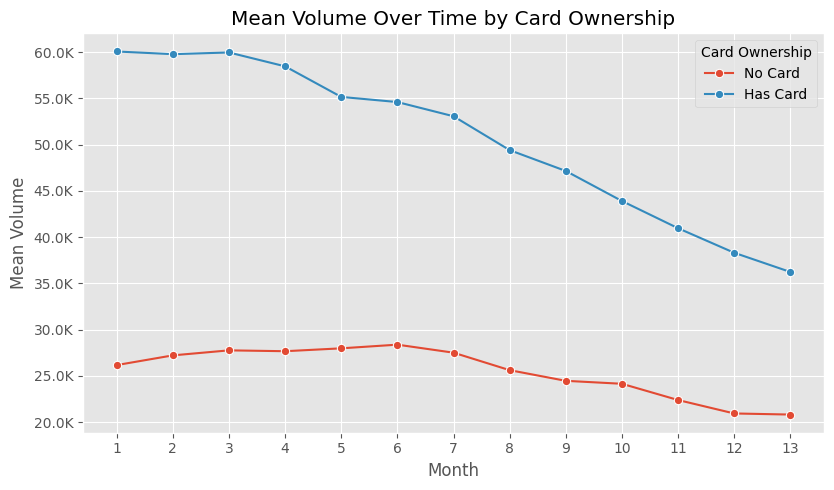

In [64]:
from src.plot_utils import plot_agg_variables

plot_agg_variables(client_df, 'volume', ['mean'])

## Train-Test-Split

In [65]:
from src.train_utils import train_test_split_bal

cleaned_client_df = client_df.loc[:, ~client_df.columns.str.contains('_id|id_|_date|card_issued|age_bracket|card_type')]

X_train, X_test, y_train, y_test = train_test_split_bal(df=cleaned_client_df, target_column='has_card', test_size=0.2, random_state=1337, balancing_technique='undersample')

In [66]:
print('Train set:')
print(y_train.value_counts(normalize=True))
print('\nTest set:')
print(y_test.value_counts(normalize=True))

Train set:
has_card
False    0.5
True     0.5
Name: proportion, dtype: float64

Test set:
has_card
False    0.792732
True     0.207268
Name: proportion, dtype: float64


## Baseline Model
Erstellen eines Baseline Modelles mittels logistischer Regression und den Informationen “Alter”,
“Geschlecht”, “Domizilregion”, “Vermögen” und “Umsatz” vor Kreditkartenkauf.

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 230.63it/s]


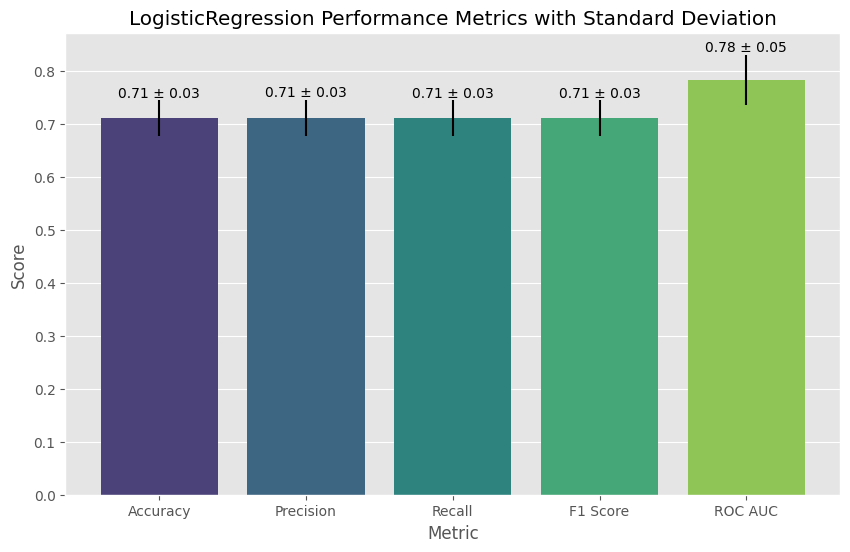

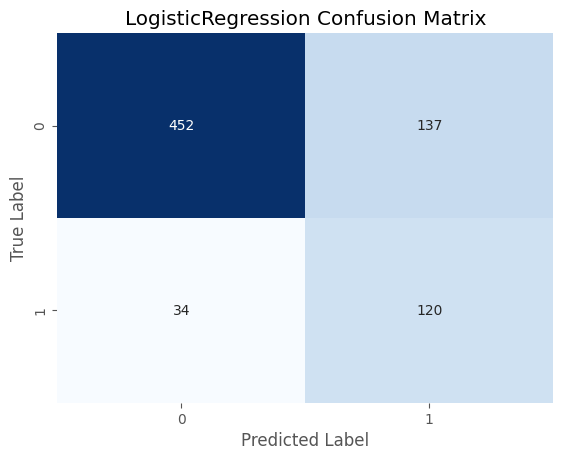

In [67]:
from src.plot_utils import (plot_roc_curve, 
                            plot_confusion_matrix, 
                            plot_lift_curve, 
                            plot_precision_recall_curve, 
                            plot_metrics,
                            plot_param_grid_heatmap)

from src.train_utils import (cross_validate,
                             build_preprocessor_pipeline)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

baseline_columns = ['client_age', 'client_gender', 'client_district_region']

baseline_preprocessor, baseline_column_selection = build_preprocessor_pipeline(X_train, 
                                                                               include_columns=baseline_columns, 
                                                                               regex_columns='(volume|balance)')

base_pipeline = Pipeline([
    ('preprocessor', baseline_preprocessor),
    ('classifier', LogisticRegression(random_state=1337, max_iter=10_000))
])

(base_estimator, 
 base_params, 
 base_metrics_df, 
 base_roc_curves, 
 base_pr_curves, 
 base_lift_probs, 
 base_true_labels,
 _) = cross_validate(base_pipeline, 
                     baseline_column_selection, 
                     y_train)

model_name = base_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(base_metrics_df, model_name)
plot_confusion_matrix(base_estimator, X_test[baseline_column_selection.columns], y_test, model_name)

In [68]:
base_metrics_df

Accuracy  Precision    Recall  F1 Score   ROC AUC
0  0.705882   0.706407  0.705882  0.705695  0.782148
1  0.708861   0.709285  0.708861  0.708757  0.781228
2  0.742616   0.743402  0.742616  0.742359  0.814058
3  0.658228   0.658227  0.658228  0.658216  0.708446
4  0.738397   0.740199  0.738397  0.737977  0.831149

## Further Model Candidates

### Logistic Regression

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 3807.47it/s]


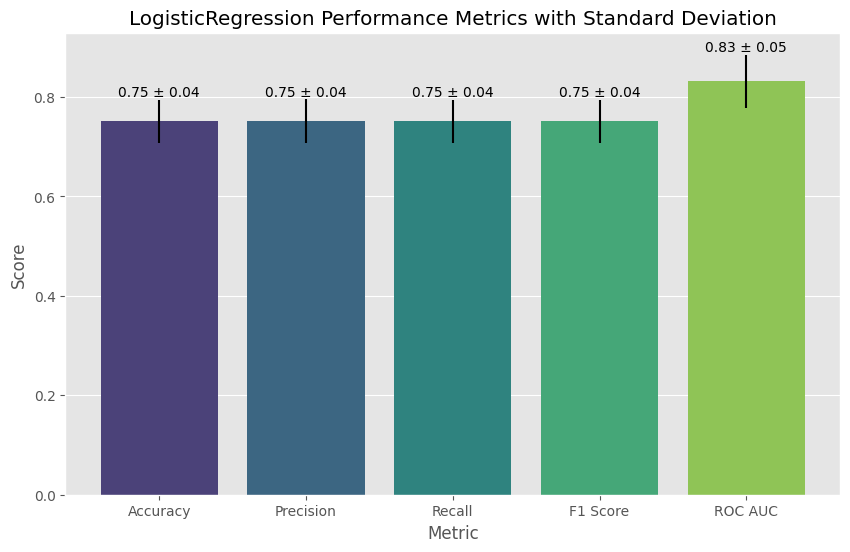

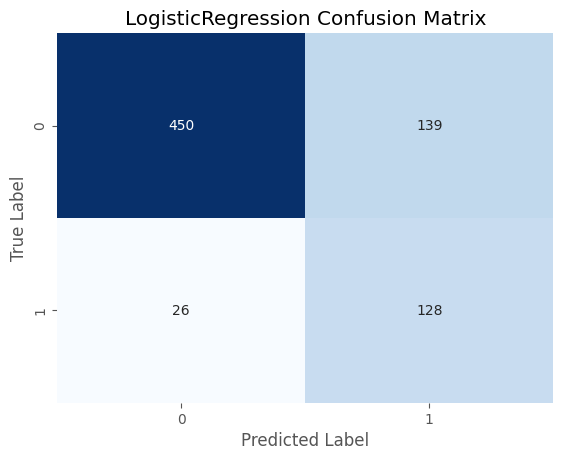

In [69]:
all_vars_prep_pipeline, all_vars_column_selection  = build_preprocessor_pipeline(X_train, include_columns=X_train.columns.tolist())

lr_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', LogisticRegression(random_state=1337, max_iter=100_000, solver='saga'))
])

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
}

(lr_estimator,
 lr_params,
 lr_metrics_df,
 lr_roc_curves,
 lr_pr_curves,
 lr_lift_probs,
 lr_true_labels,
 lr_grid_search) = cross_validate(lr_pipeline, all_vars_column_selection, y_train, param_grid=lr_param_grid)

model_name = lr_estimator.named_steps['classifier'].__class__.__name__
plot_metrics(lr_metrics_df, model_name)
plot_confusion_matrix(lr_estimator, X_test[all_vars_column_selection.columns], y_test, model_name)

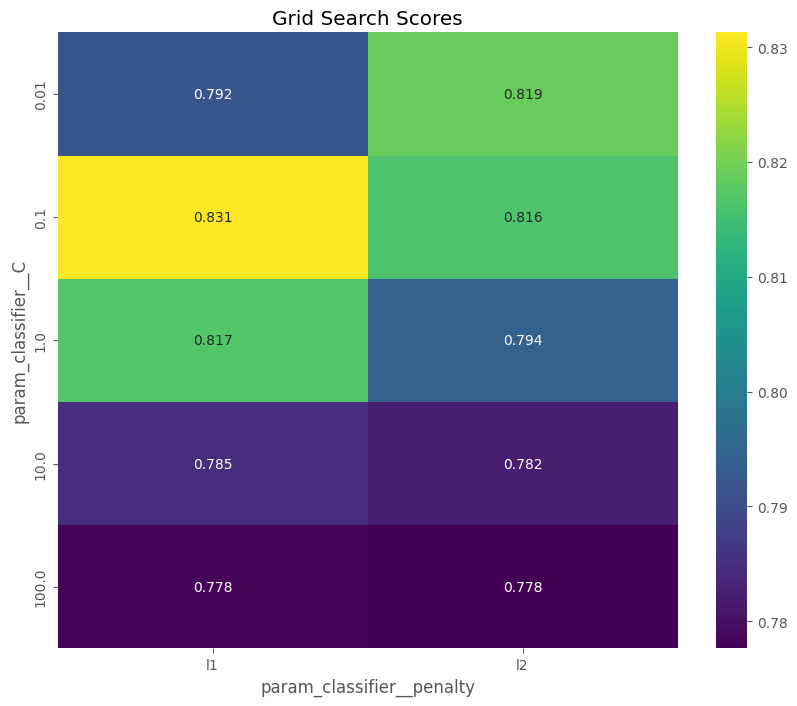

In [70]:
plot_param_grid_heatmap(lr_grid_search)

### Decision Tree

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 3455.51it/s]


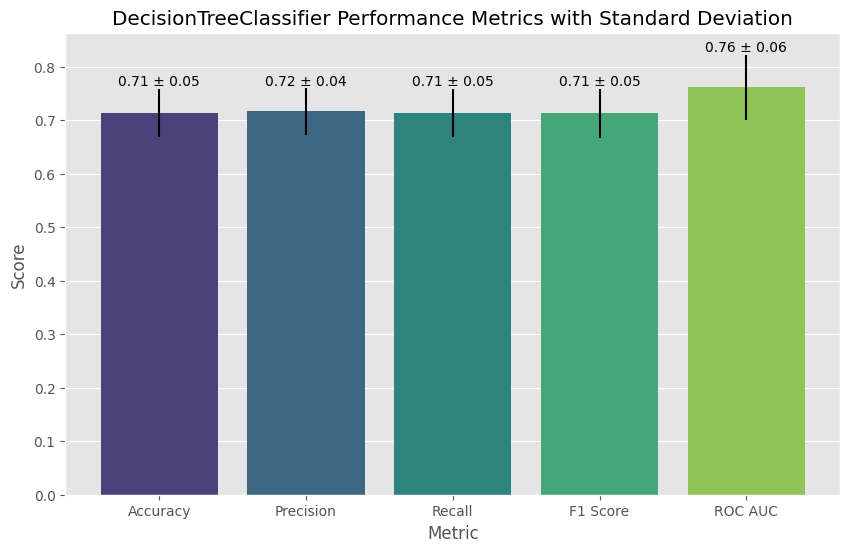

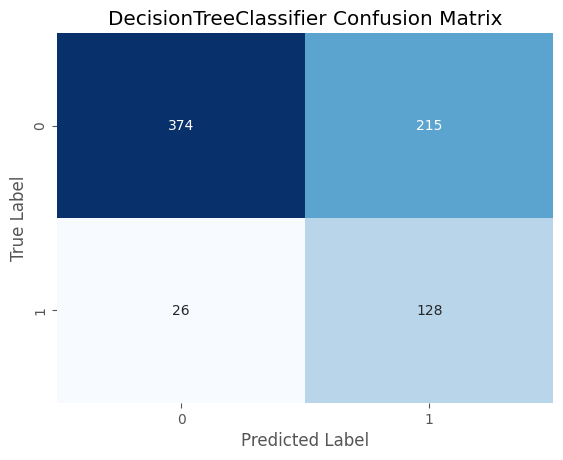

In [71]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=1337))
])

dt_param_grid = {
    'classifier__max_depth': [5, 10, 20, 30, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

(dt_estimator, 
 dt_params, 
 dt_metrics_df, 
 dt_roc_curves, 
 dt_pr_curves, 
 dt_lift_probs, 
 dt_true_labels,
 dt_grid_search) = cross_validate(pipeline=dt_pipeline, 
                                  X=all_vars_column_selection, 
                                  y=y_train,
                                  param_grid=dt_param_grid)

model_name = dt_estimator.named_steps['classifier'].__class__.__name__
plot_metrics(dt_metrics_df, model_name)
plot_confusion_matrix(dt_estimator, X_test[all_vars_column_selection.columns], y_test, model_name)

## Random Forest

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 3674.06it/s]


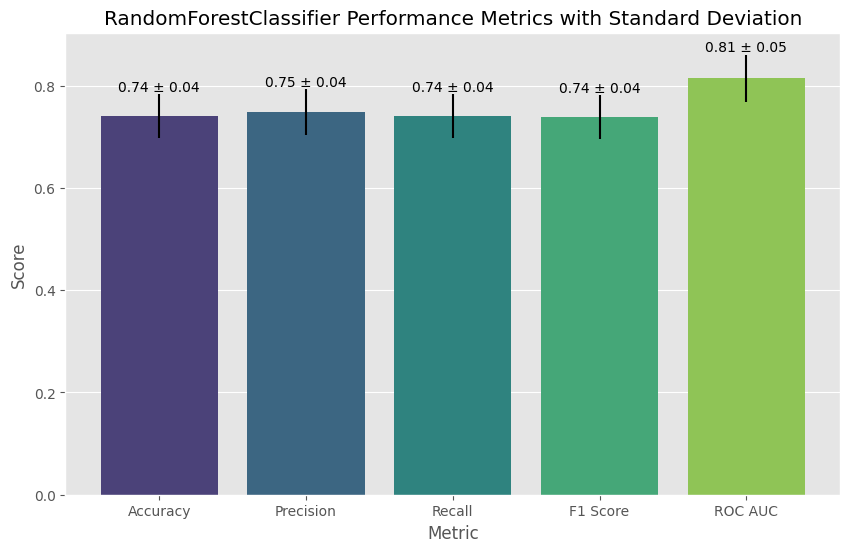

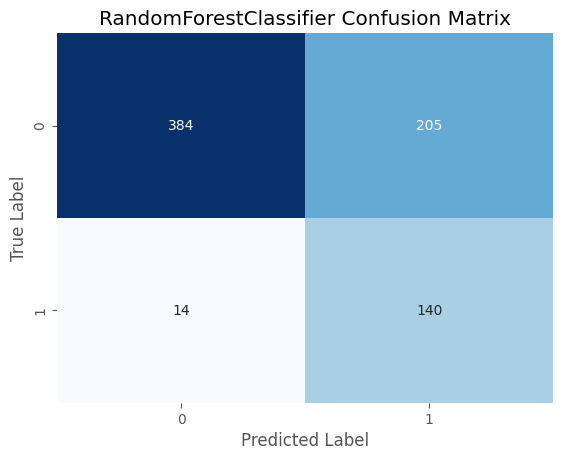

In [72]:
from sklearn.ensemble import RandomForestClassifier

all_vars_prep_pipeline, all_vars_column_selection = build_preprocessor_pipeline(X_train, include_columns=X_train.columns.tolist())

rf_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', RandomForestClassifier(random_state=1337))
])

rf_param_grid = {
    'classifier__max_depth': [5, 10, 20, 30, 50],
    'classifier__n_estimators': [10, 20, 30]
}

(rf_estimator, 
 rf_params, 
 rf_metrics_df, 
 rf_roc_curves, 
 rf_pr_curves, 
 rf_lift_probs, 
 rf_true_labels,
 rf_grid_search) = cross_validate(rf_pipeline, 
                                  X_train[all_vars_column_selection.columns], 
                                  y_train, 
                                  param_grid=rf_param_grid)

model_name = rf_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(rf_metrics_df, model_name)
plot_confusion_matrix(rf_estimator, X_test[all_vars_column_selection.columns], y_test, model_name)

## Bagging

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 1490.30it/s]


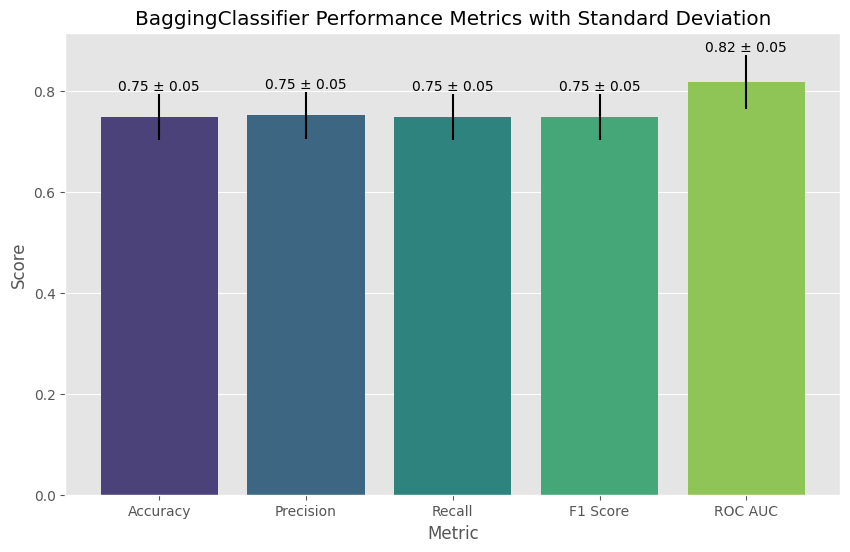

In [73]:
from sklearn.ensemble import BaggingClassifier

bg_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', BaggingClassifier(random_state=1337))
])

bg_param_grid = {
    'classifier__n_estimators': [10, 20, 30],
    'classifier__max_features': [10, 20, 30, 40, 50]
}

(bg_estimator, 
 bg_params, 
 bg_metrics_df, 
 bg_roc_curves, 
 bg_pr_curves, 
 bg_lift_probs, 
 bg_true_labels,
 bg_grid_search) = cross_validate(bg_pipeline,
                                  all_vars_column_selection, 
                                  y_train, 
                                  param_grid=bg_param_grid)

model_name = bg_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(bg_metrics_df, model_name)

## Boosting

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 3804.70it/s]


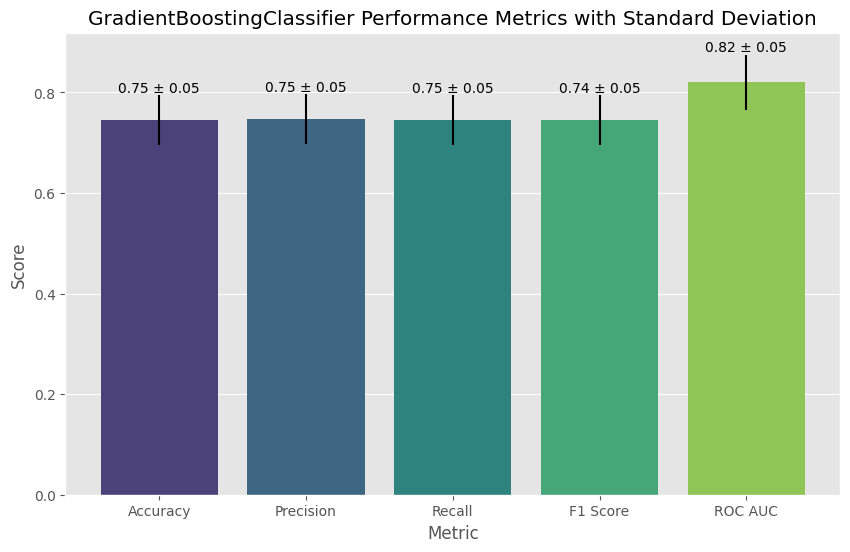

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

bt_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', GradientBoostingClassifier(random_state=1337))
])

bt_param_grid = {
    'classifier__n_estimators': [10, 20, 30],
    'classifier__learning_rate': [0.01, 0.1, 1],
    'classifier__max_depth': [5, 10, 20]
}

(bt_estimator, 
 bt_params, 
 bt_metrics_df, 
 bt_roc_curves, 
 bt_pr_curves, 
 bt_lift_probs, 
 bt_true_labels,
 bt_grid_search) = cross_validate(bt_pipeline,
                                  all_vars_column_selection, 
                                  y_train, 
                                  param_grid=bt_param_grid)

model_name = bt_estimator.named_steps['classifier'].__class__.__name__

plot_metrics(bt_metrics_df, model_name)

## Comparing the Model Candidates

### ROC Curves

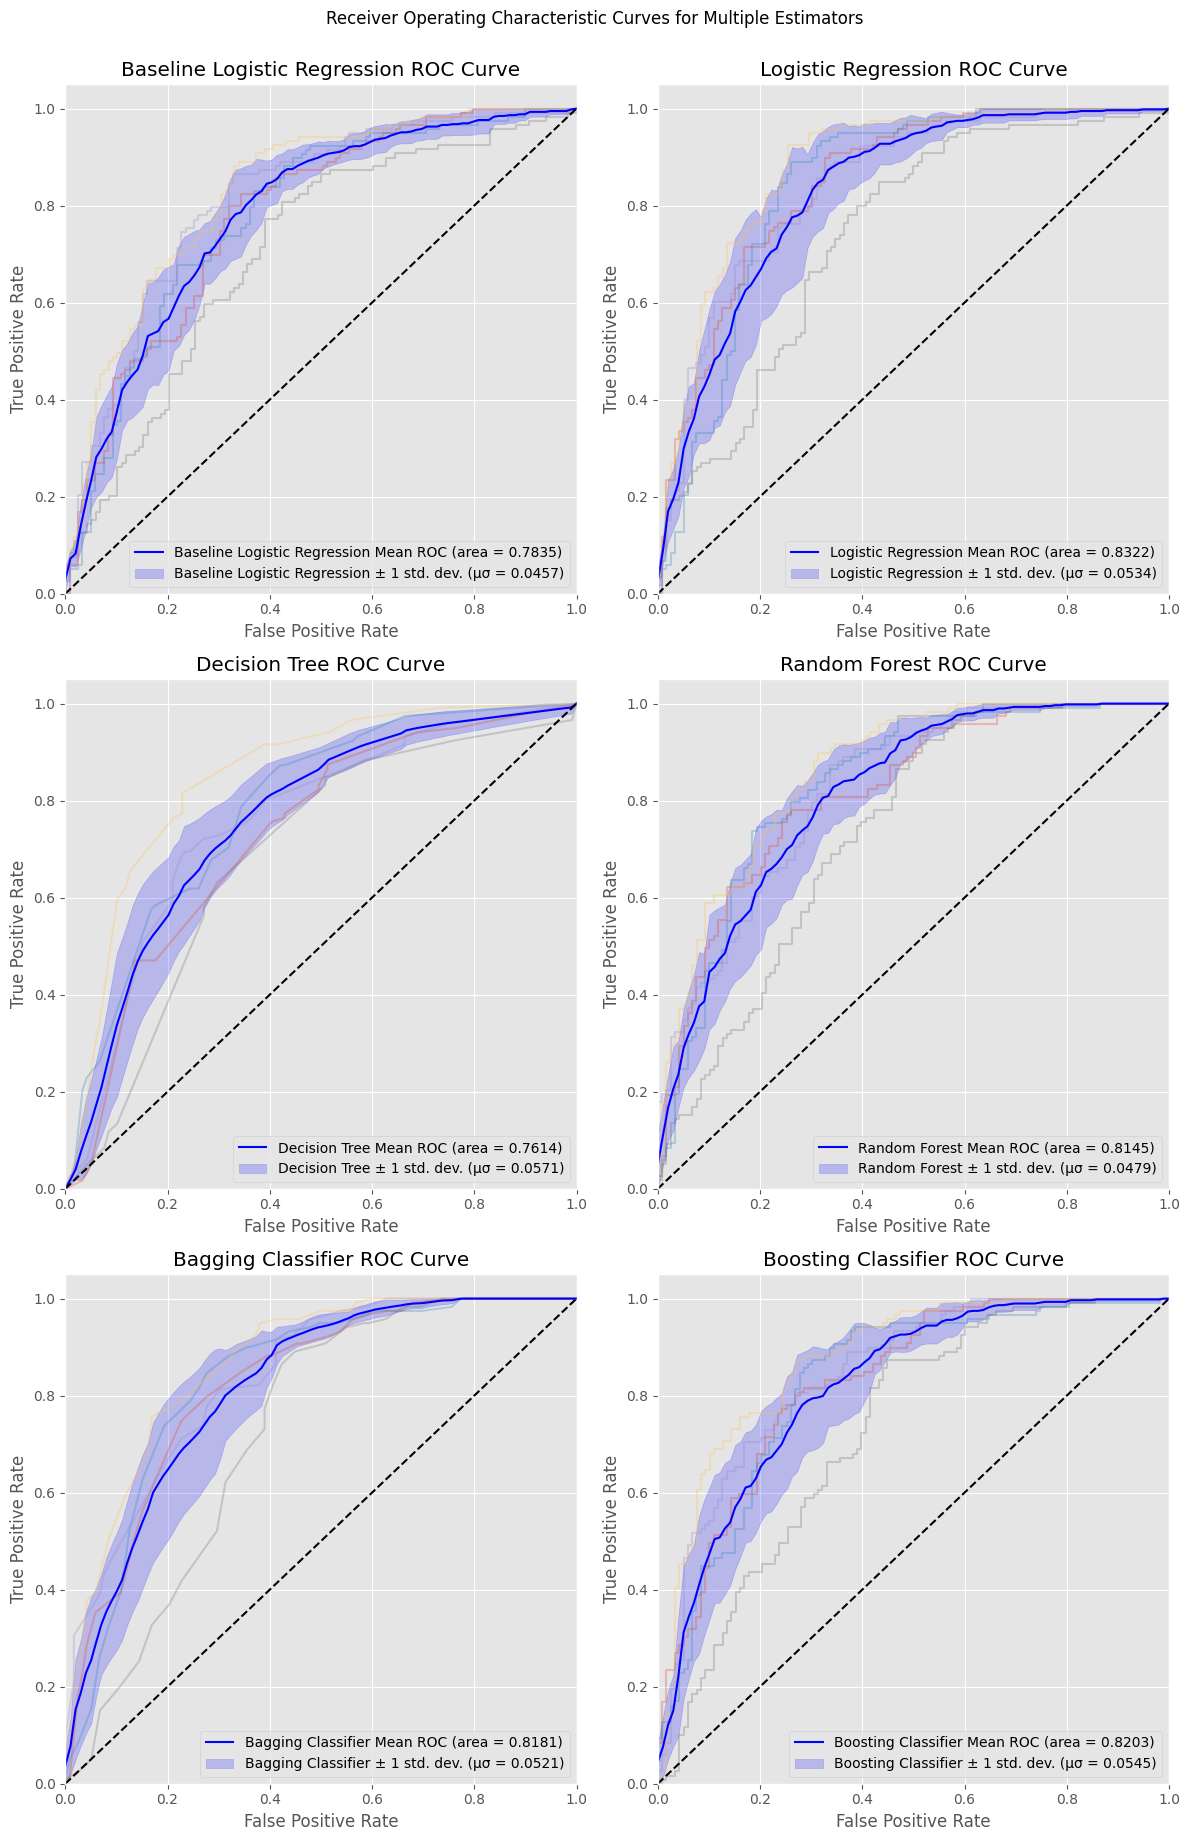

In [75]:
from src.plot_utils import plot_multiple_roc_curves

plot_multiple_roc_curves([base_roc_curves, lr_roc_curves, dt_roc_curves, rf_roc_curves, bg_roc_curves, bt_roc_curves], 
                         ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'])

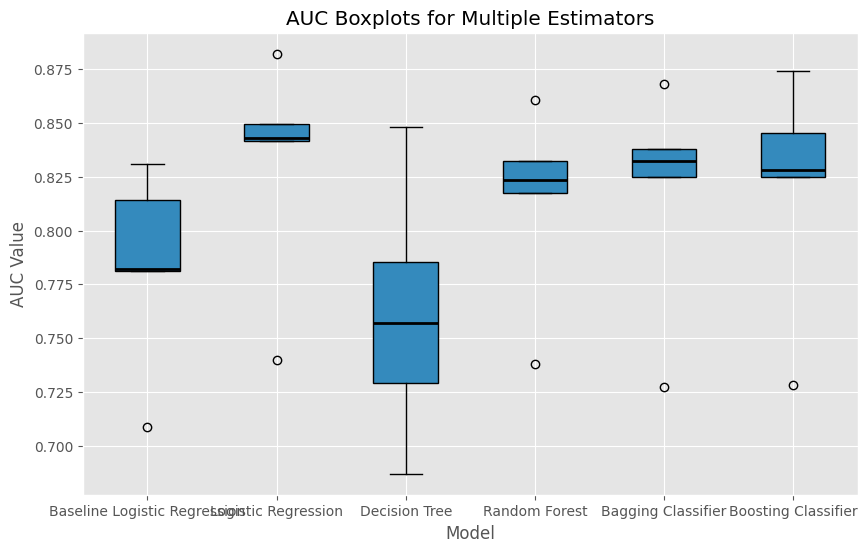

In [76]:
from src.plot_utils import plot_auc_boxplots

plot_auc_boxplots([base_roc_curves, lr_roc_curves, dt_roc_curves, rf_roc_curves, bg_roc_curves, bt_roc_curves], 
                  ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'])

### Confusion Matrices

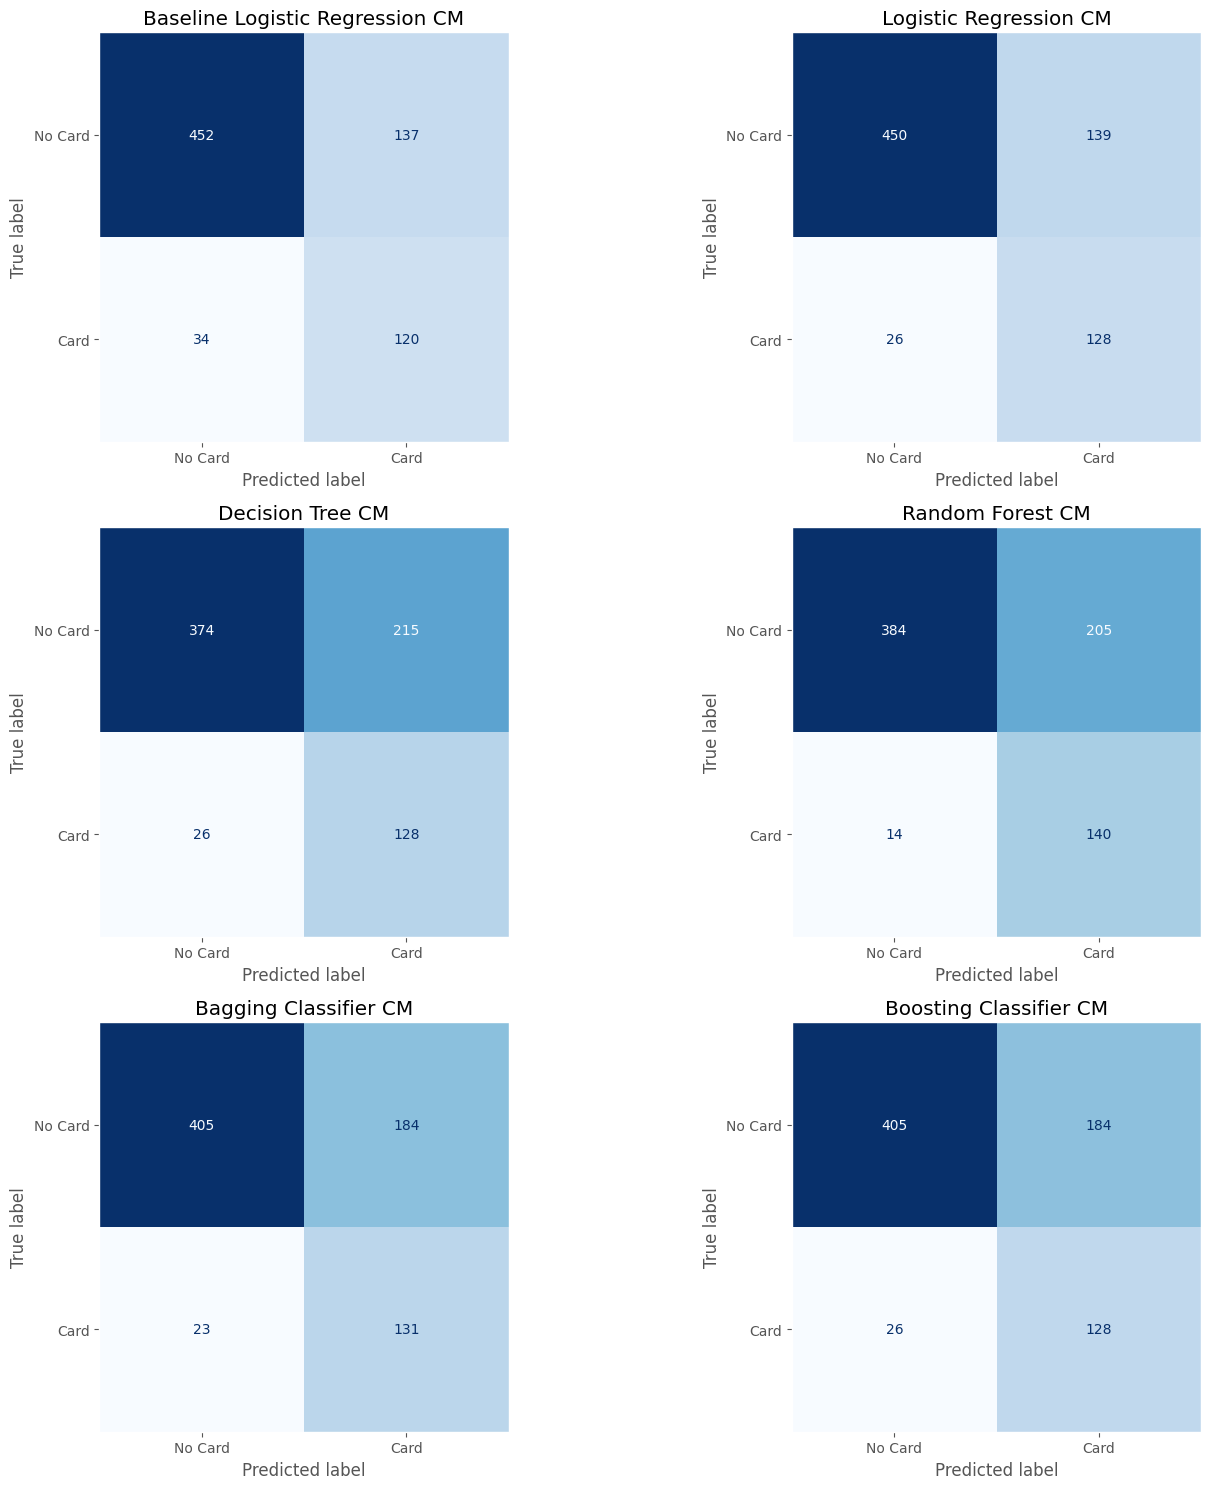

In [77]:
from src.plot_utils import plot_confusion_matrices

plot_confusion_matrices([base_estimator, lr_estimator, dt_estimator, rf_estimator, bg_estimator, bt_estimator], 
                        X_test[all_vars_column_selection.columns], 
                        y_test,
                        ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'])

### Other Metrics

In [78]:
average_metrics = []

for name, df in zip(['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier', 'Boosting Classifier'], 
                    [base_metrics_df, lr_metrics_df, dt_metrics_df, rf_metrics_df, bg_metrics_df, bt_metrics_df]):
    mean_metrics = df.mean()
    mean_metrics['Estimator'] = name
    average_metrics.append(mean_metrics)

average_metrics_df = pd.DataFrame(average_metrics)[['Estimator', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']]

average_metrics_df

Estimator  Accuracy  Precision    Recall  F1 Score  \
0  Baseline Logistic Regression  0.710797   0.711504  0.710797  0.710601   
1           Logistic Regression  0.751261   0.751741  0.751261  0.751156   
2                 Decision Tree  0.713357   0.716122  0.713357  0.712285   
3                 Random Forest  0.740322   0.748519  0.740322  0.738179   
4            Bagging Classifier  0.748729   0.751649  0.748729  0.747976   
5           Boosting Classifier  0.745346   0.746812  0.745346  0.744910   

    ROC AUC  
0  0.783406  
1  0.831290  
2  0.761376  
3  0.814467  
4  0.818094  
5  0.820061

## Model Reduction

### Selecting Features

In [79]:
lr_rfe_pipeline = Pipeline([
    ('preprocessor', all_vars_prep_pipeline),
    ('classifier', LogisticRegression(**lr_estimator.named_steps['classifier'].get_params()))
])

(lr_rfe_estimator,
 lr_rfe_params,
 lr_rfe_metrics_df,
 lr_rfe_roc_curves,
 lr_rfe_pr_curves,
 lr_rfe_lift_probs,
 lr_rfe_true_labels,
 _) = cross_validate(lr_rfe_pipeline, all_vars_column_selection, y_train, n_features_to_select=20)

Cross-Validation: 100%|██████████| 5/5 [00:00<00:00, 738.43it/s]


In [80]:
rfe_step = lr_rfe_estimator.named_steps['rfe']
column_ids = rfe_step.get_support()

rfe_selected_columns = lr_rfe_estimator.named_steps['preprocessor'].get_feature_names_out()[column_ids]

pd.DataFrame(rfe_selected_columns, columns=['Selected Features'])

Selected Features
0                                     num__client_age
1   num__client_district_n_municipalities_with_inh...
2                            num__volume_month_diff_4
3                            num__credit_month_diff_4
4                    num__n_transactions_month_diff_1
5                   num__n_transactions_month_diff_13
6                                    num__account_age
7                                   num__region_match
8                         num__pre_card_volume_median
9                            num__pre_card_credit_min
10                        num__pre_card_credit_median
11                   num__pre_card_n_transactions_sum
12                num__pre_card_n_transactions_median
13                      num__n_transactions_month_min
14                      num__n_transactions_month_max
15                     num__balance_first_quarter_std
16              num__n_transactions_first_quarter_std
17                      num__volume_first_quarter_min
18                      num__credit_first_quarter_min
19             cat__account_frequency_MONTHLY CHARGES

## Model Explanation

In [81]:
from dalex import Explainer

X_train_rfe_prep = lr_rfe_estimator.named_steps['preprocessor'].transform(X_train[all_vars_column_selection.columns])
X_train_rfe_selected_cols = lr_rfe_estimator.named_steps['rfe'].transform(X_train_rfe_prep)

X_train_rfe_selected_cols = X_train_rfe_selected_cols.toarray()

X_train_rfe_selected_cols = pd.DataFrame(X_train_rfe_selected_cols, columns=rfe_selected_columns)

explainer = Explainer(lr_rfe_estimator.named_steps['classifier'], X_train_rfe_selected_cols, y_train, label='Reduced Logistic Regression')

Preparation of a new explainer is initiated

  -> data              : 1186 rows 20 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1186 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Reduced Logistic Regression
  -> predict function  : <function yhat_proba_default at 0x17ee2e700> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.023, mean = 0.5, max = 0.994
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.994, mean = -0.000496, max = 0.944
  -> model_info        : package sklearn

A new explainer has been created!


In [82]:
explainer.model_performance()

In [83]:
explainer.model_parts(type='variable_importance').plot()

In [84]:
pd_rf = explainer.model_profile()

pd_rf.plot()

Calculating ceteris paribus: 100%|██████████| 20/20 [00:00<00:00, 77.48it/s]


## Top Customer Lists

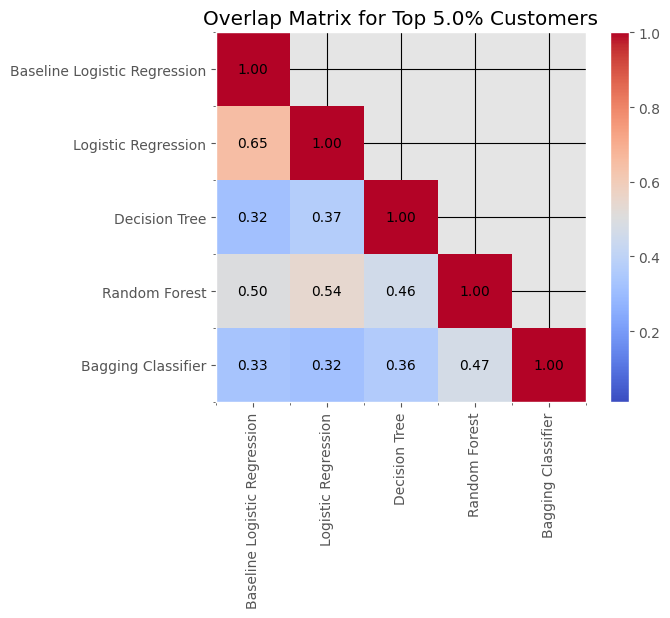

In [85]:
from src.plot_utils import plot_model_concordance

estimators = [base_estimator, lr_estimator, dt_estimator, rf_estimator, bg_estimator]
estimator_names = ['Baseline Logistic Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Bagging Classifier']
non_card_holders = cleaned_client_df[cleaned_client_df['has_card'] == False].drop(columns='has_card')

plot_model_concordance(estimators, estimator_names, non_card_holders, p=0.05)

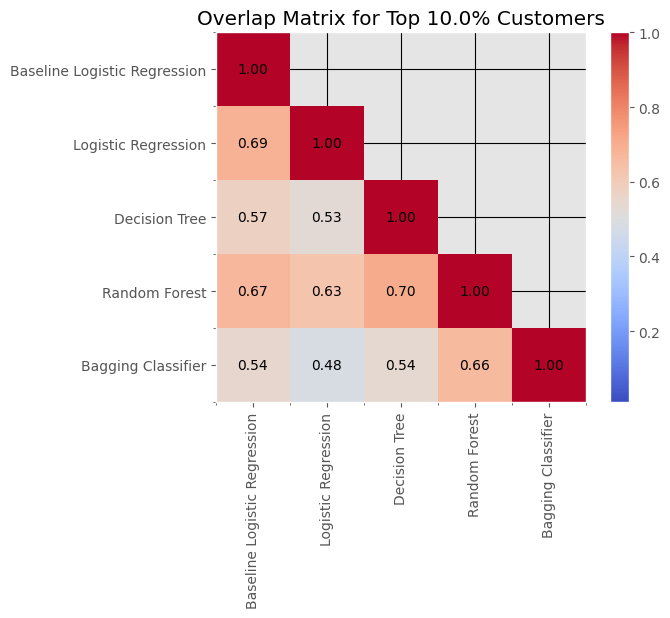

In [86]:
plot_model_concordance(estimators, estimator_names, non_card_holders, p=0.1)

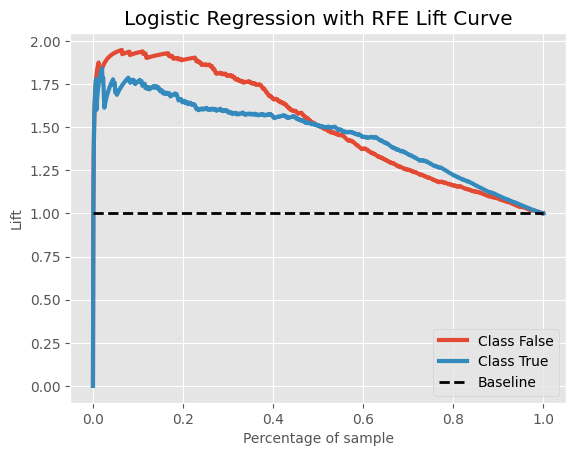

In [87]:
plot_lift_curve(lr_rfe_lift_probs, lr_rfe_true_labels, 'Logistic Regression with RFE')